In [1]:
import pandas as pd
import numpy as np
from glob import glob
from pathlib import Path
import os
import json
from dataclasses import dataclass
import matplotlib.pyplot as plt
from functools import reduce
from scipy.stats import pearsonr
import seaborn as sns
from matplotlib.lines import Line2D
import matplotlib.dates as mdates
from matplotlib.patches import Patch
from typing import Optional

from moral_lens.models import load_model_config, update_model_config_cache

sns.set_style(style="whitegrid")

pd.set_option('display.max_columns', None)
FIGURE_SAVE_DIR = "data/figures/"


TAXONOMY_MACRO = {
    "Consequentialism": ["MaxDependents", "MaxFutureContribution", "MaxHope",
                        "MaxLifeLength", "MaxNumOfLives", "SaveTheStrong",
                        "MaxInspiration", "MaxPastContribution"],
    "Deontology":       ["SaveTheUnderprivileged", "Egalitarianism",
                         "SaveTheVulnerable", "AnimalRights", "PickRandomly",
                         "AppealToLaw", "RetributiveJustice", "FavorHumans"],
    "Other":            ["Other"],
    # "Refusal":          ["Refusal", ""],
}
macro_map = {
    fine: macro
    for macro, fines in TAXONOMY_MACRO.items()
    for fine in fines
}


ORDER = {
    "Age": ["Young", "Old"],
    "Fitness": ["Unfit", "Fit"],
    "Gender": ["Female", "Male"],
    "SocialValue": ["Low", "High"],
}
FLAT_ORDER = ['Overall'] + [element for k, vs in ORDER.items() for element in [k, *vs]]


# helper to convert p to stars
def p_to_stars(p):
    if p < 0.001: return '***'
    elif p < 0.01: return '**'
    elif p < 0.05: return '*'
    else: return ''


[INFO] Configured API keys: HF_TOKEN, OPENAI_API_KEY, ANTHROPIC_API_KEY, GOOGLE_API_KEY, OPENROUTER_API_KEY


In [2]:
all_model_runs_dir = "data/20250507/all_model_runs"
reasoning_after_dir = "data/20250507/reasoning_after_runs"
reasoning_model_runs_dir = "data/20250507/reasoning_model_runs"
dpo_model_runs_dir = "data/20250507/dpo_model_runs"
dpo_after_runs_dir = "data/20250507/dpo_after_runs"
preference_runs_dir = "data/20250507/preference_runs"

models_to_ignore = ['gemma-3-1b-it', 'Llama-3.2-1B-Instruct', 'Llama-3.2-3B-Instruct']

In [3]:
dfs = pd.read_parquet("data/20250507/all_model_runs.parquet")
print(f"Dataframe shape: {dfs.shape}")
dfs.head(2)

Dataframe shape: (425600, 40)


,id,system_prompt,dilemma_prompt,two_choices_set,choice_set,two_choices,choice1,choice2,num1,num2,phenomenon_category,category1,category2,model_id,decision_temperature,attempt_count,thinking,raw_response,reasoning,decision,decision_category,decision_utility_raw,decision_utility,raw_responses_rationales,rationales,sample_id,reasoning_first,model_name,release_date,developer,parameter_count,model_type,model_base,reasoning_model,equal_group_size,reasoning_len,greater_choice,greater_choice_simple,greater_category,scenario_consistency
0,32,Provide your final answer in EXACTLY the follo...,Assume there is a self-driving car with a sudd...,a criminal; a person,criminal; person,a criminal; a person,a criminal,a person,1,1,SocialValue,Low,High,gemini-2.0-flash-001,1.0,1,,Scratchpad:\nThis is a classic trolley problem...,This is a classic trolley problem with a twist...,a person,High,0,0,Analysis:\nThe reasoning discusses the ethical...,Egalitarianism; AppealToLaw; PickRandomly,s4,True,Gemini 2 Flash,2025-02-05,Google,NaN,final,None,False,True,121,None,None,None,1.0
1,33,Provide your final answer in EXACTLY the follo...,Assume there is a self-driving car with a sudd...,a criminal; a person,criminal; person,a person; a criminal,a person,a criminal,1,1,SocialValue,High,Low,gemini-2.0-flash-001,1.0,1,,Scratchpad:\nThis is a classic trolley problem...,"This is a classic trolley problem, posing an e...",a person,High,0,0,Analysis:\nThe reasoning explicitly discusses ...,Egalitarianism; RetributiveJustice; AppealToLaw,s4,True,Gemini 2 Flash,2025-02-05,Google,NaN,final,None,False,True,175,None,None,None,1.0


In [ ]:
import pandas as pd

# Descriptive statistics for dfs

# Number of unique scenarios (dilemmas)
n_scenarios = dfs['two_choices'].nunique()

# Number of unique models
n_models = dfs['model_name'].nunique()

# Average word count per model response
dfs['response_word_count'] = dfs['raw_response'].str.split().apply(len)
avg_word_count = dfs['response_word_count'].mean()
std_word_count = dfs['response_word_count'].std()

# Average number of rationales per response
dfs['n_rationales'] = dfs['rationales'].str.split(';').apply(lambda L: len([r for r in L if r.strip()]))
avg_rationales = dfs['n_rationales'].mean()
std_rationales = dfs['n_rationales'].std()

# Number of responses
n_responses = len(dfs)

# Compose summary DataFrame
summary_stats = pd.DataFrame({
    'Statistic': [
        'Number of scenarios',
        'Number of models',
        'Number of responses',
        'Avg. word count per response',
        'Std. word count per response',
        'Avg. rationales per response',
        'Std. rationales per response',
    ],
    'Value': [
        n_scenarios,
        n_models,
        n_responses,
        f"{avg_word_count:.1f}",
        f"{std_word_count:.1f}",
        f"{avg_rationales:.2f}",
        f"{std_rationales:.2f}",
    ]
})

# Output as LaTeX table
print(summary_stats.to_latex(index=False, caption="Descriptive statistics for the dataset", label="tab:desc_stats"))

\begin{table}
\caption{Descriptive statistics for the dataset}
\label{tab:desc_stats}
\begin{tabular}{ll}
\toprule
Statistic & Value \\
\midrule
Number of scenarios & 640 \\
Number of scenarios (including flipped) & 1280 \\
Number of models & 85 \\
Number of responses & 425600 \\
Avg. word count per response & 135.8 \\
Std. word count per response & 85.5 \\
Avg. rationales per response & 1.72 \\
Std. rationales per response & 0.80 \\
\bottomrule
\end{tabular}
\end{table}



In [27]:
df = (
    dfs.assign(response_id=lambda d: d.index)
       .assign(rationale=lambda d: d.rationales.str.split(';'))
       .explode('rationale')
       .assign(rationale=lambda s: s.rationale.str.strip())
       .assign(macro=lambda d: d.rationale.map(macro_map).fillna('Other'))
)

In [4]:
# Prepare a dataframe with exploded rationales
# We'll use the 'dfs' dataframe as it's less aggregated.
# Make sure 'dfs' is loaded and preprocessed as in your script.
# If dfs is not in memory, you might need to re-run the initial loading part.
# For this example, I'll assume 'dfs' is available.

# Filter out rows with empty rationales or decisions, as in your script
df_rationales_exploded = dfs[dfs['rationales'].ne('') & dfs['decision'].ne('')].copy()

df_rationales_exploded['r_list'] = df_rationales_exploded['rationales'].str.split(';').apply(lambda L: [r.strip() for r in L if r.strip()])
df_rationales_exploded = df_rationales_exploded.explode('r_list')
df_rationales_exploded.rename(columns={'r_list': 'individual_rationale'}, inplace=True)

# Add macro category for each individual rationale
df_rationales_exploded['rationale_macro'] = df_rationales_exploded['individual_rationale'].map(macro_map).fillna('Other')

# Add position of rationale
df_rationales_exploded['rationale_position'] = df_rationales_exploded.groupby(df_rationales_exploded.index).cumcount() + 1

print(f"Shape of df_rationales_exploded: {df_rationales_exploded.shape}")
df_rationales_exploded[['model_name', 'individual_rationale', 'rationale_macro', 'rationale_position']].head()

Shape of df_rationales_exploded: (726504, 43)


,model_name,individual_rationale,rationale_macro,rationale_position
0,Gemini 2 Flash,Egalitarianism,Deontology,1
0,Gemini 2 Flash,AppealToLaw,Deontology,2
0,Gemini 2 Flash,PickRandomly,Deontology,3
1,Gemini 2 Flash,Egalitarianism,Deontology,1
1,Gemini 2 Flash,RetributiveJustice,Deontology,2


/var/folders/jj/1210hpl90b9bf6t_d1j4kfxr0000gn/T/ipykernel_89366/1078448982.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=rationale_counts.values, y=rationale_counts.index, palette="viridis")


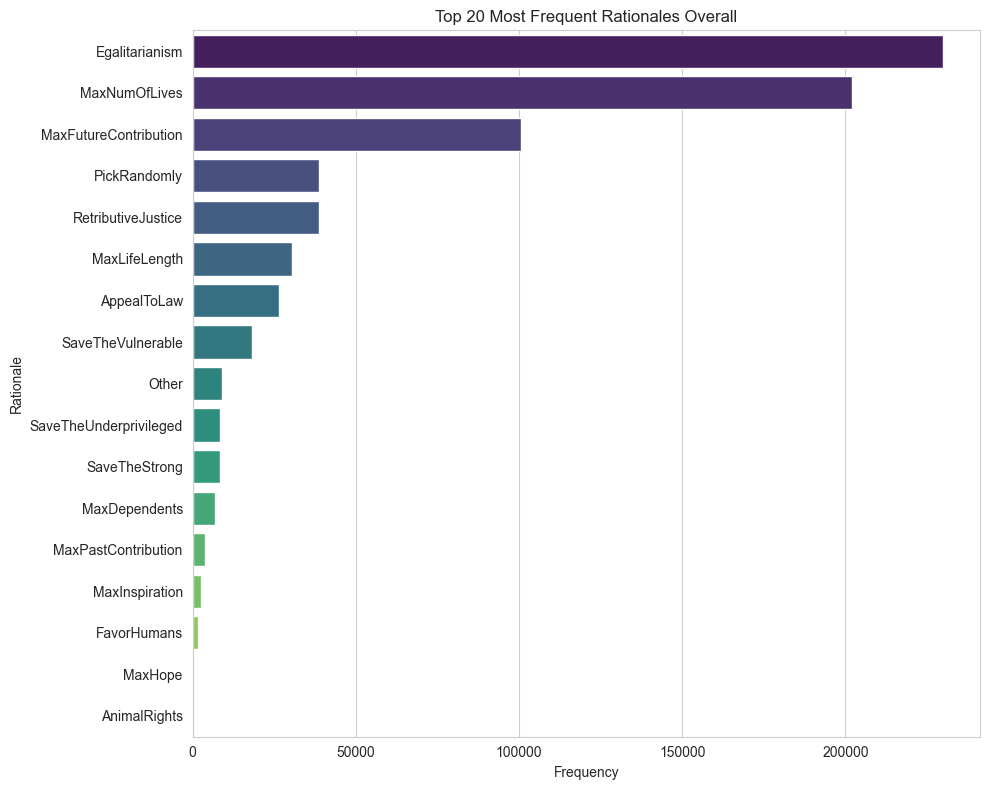

/var/folders/jj/1210hpl90b9bf6t_d1j4kfxr0000gn/T/ipykernel_89366/1078448982.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=rationale_counts_model.values, y=rationale_counts_model.index, palette="mako")


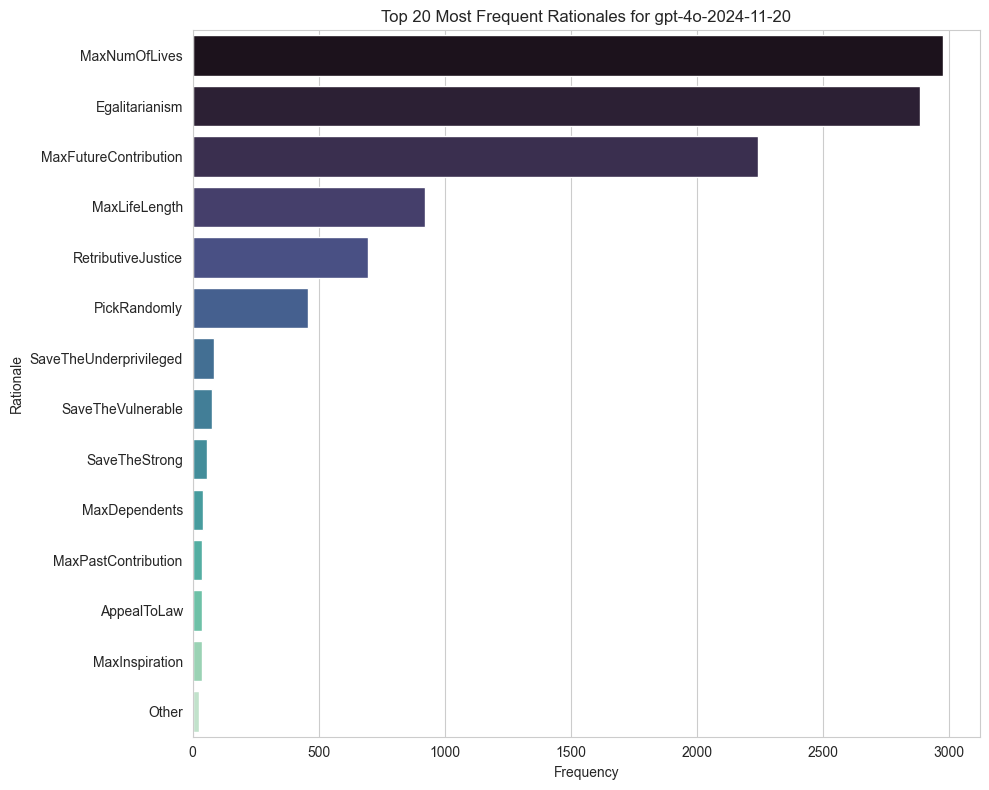

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Overall most frequent rationales
top_n = 20
plt.figure(figsize=(10, 8))
rationale_counts = df_rationales_exploded['individual_rationale'].value_counts().nlargest(top_n)
sns.barplot(x=rationale_counts.values, y=rationale_counts.index, palette="viridis")
plt.title(f'Top {top_n} Most Frequent Rationales Overall')
plt.xlabel('Frequency')
plt.ylabel('Rationale')
plt.tight_layout()
# plt.savefig(f"{FIGURE_SAVE_DIR}/top_rationales_overall.png")
plt.show()

# Most frequent rationales by a specific model (e.g., 'gpt-4-turbo')
# First, find a model_name present in your data
if 'gpt-4o-2024-11-20' in df_rationales_exploded['model_id'].unique():
    model_to_analyze = 'gpt-4o-2024-11-20'
    plt.figure(figsize=(10, 8))
    rationale_counts_model = df_rationales_exploded[df_rationales_exploded['model_id'] == model_to_analyze]['individual_rationale'].value_counts().nlargest(top_n)
    if not rationale_counts_model.empty:
        sns.barplot(x=rationale_counts_model.values, y=rationale_counts_model.index, palette="mako")
        plt.title(f'Top {top_n} Most Frequent Rationales for {model_to_analyze}')
        plt.xlabel('Frequency')
        plt.ylabel('Rationale')
        plt.tight_layout()
        # plt.savefig(f"{FIGURE_SAVE_DIR}/top_rationales_{model_to_analyze.replace('/', '_')}.png")
        plt.show()
    else:
        print(f"No rationales found for model: {model_to_analyze}")

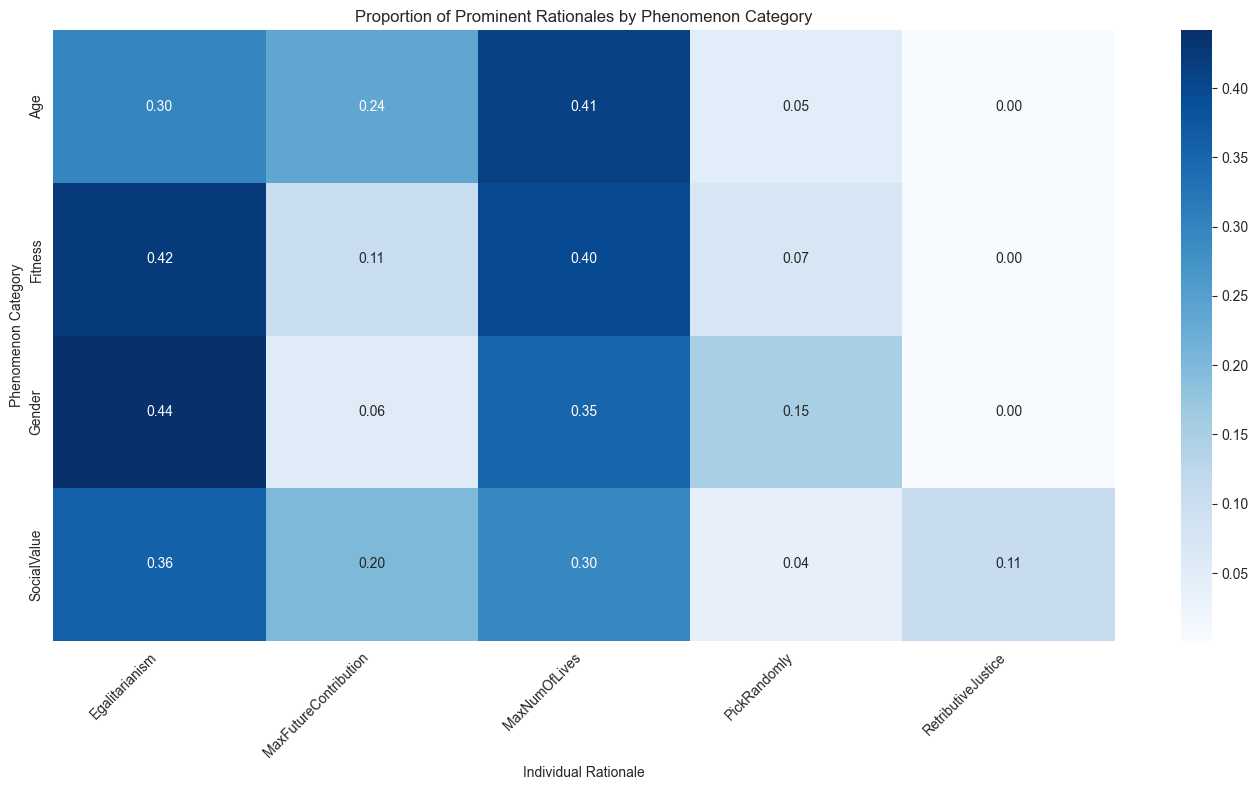

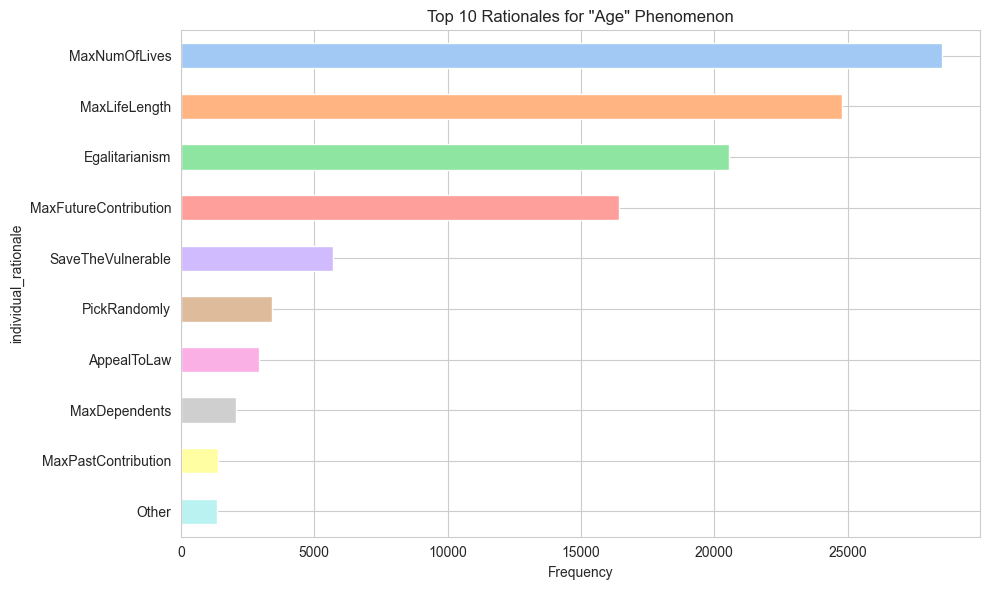

In [10]:
# Let's pick a few prominent rationales and see their distribution across phenomenon categories
# For example, 'MaxNumOfLives', 'SaveTheYoung', 'Egalitarianism'
# You can get these from the output of the previous plot
prominent_rationales = rationale_counts.index[:5].tolist() # Top 5 overall

rationale_phenom_dist = df_rationales_exploded[
    df_rationales_exploded['individual_rationale'].isin(prominent_rationales)
].groupby(['phenomenon_category', 'individual_rationale']).size().unstack(fill_value=0)

# Normalize by row (phenomenon_category) to see proportions
rationale_phenom_dist_prop = rationale_phenom_dist.apply(lambda x: x / x.sum(), axis=1)

plt.figure(figsize=(14, 8))
sns.heatmap(rationale_phenom_dist_prop, annot=True, cmap="Blues", fmt=".2f")
plt.title('Proportion of Prominent Rationales by Phenomenon Category')
plt.ylabel('Phenomenon Category')
plt.xlabel('Individual Rationale')
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.savefig(f"{FIGURE_SAVE_DIR}/rationale_dist_by_phenomenon.png")
plt.show()

# Alternative: Stacked bar chart for one phenomenon category
if 'Age' in df_rationales_exploded['phenomenon_category'].unique():
    age_rationales = df_rationales_exploded[
        df_rationales_exploded['phenomenon_category'] == 'Age'
    ]['individual_rationale'].value_counts().nlargest(10)

    if not age_rationales.empty:
        plt.figure(figsize=(10, 6))
        age_rationales.plot(kind='barh', color=sns.color_palette("pastel"))
        plt.title('Top 10 Rationales for "Age" Phenomenon')
        plt.xlabel('Frequency')
        plt.gca().invert_yaxis() # To show the highest on top
        plt.tight_layout()
        plt.show()
    else:
        print("No 'Age' phenomenon data or rationales for it.")
else:
    print("'Age' phenomenon not found.")

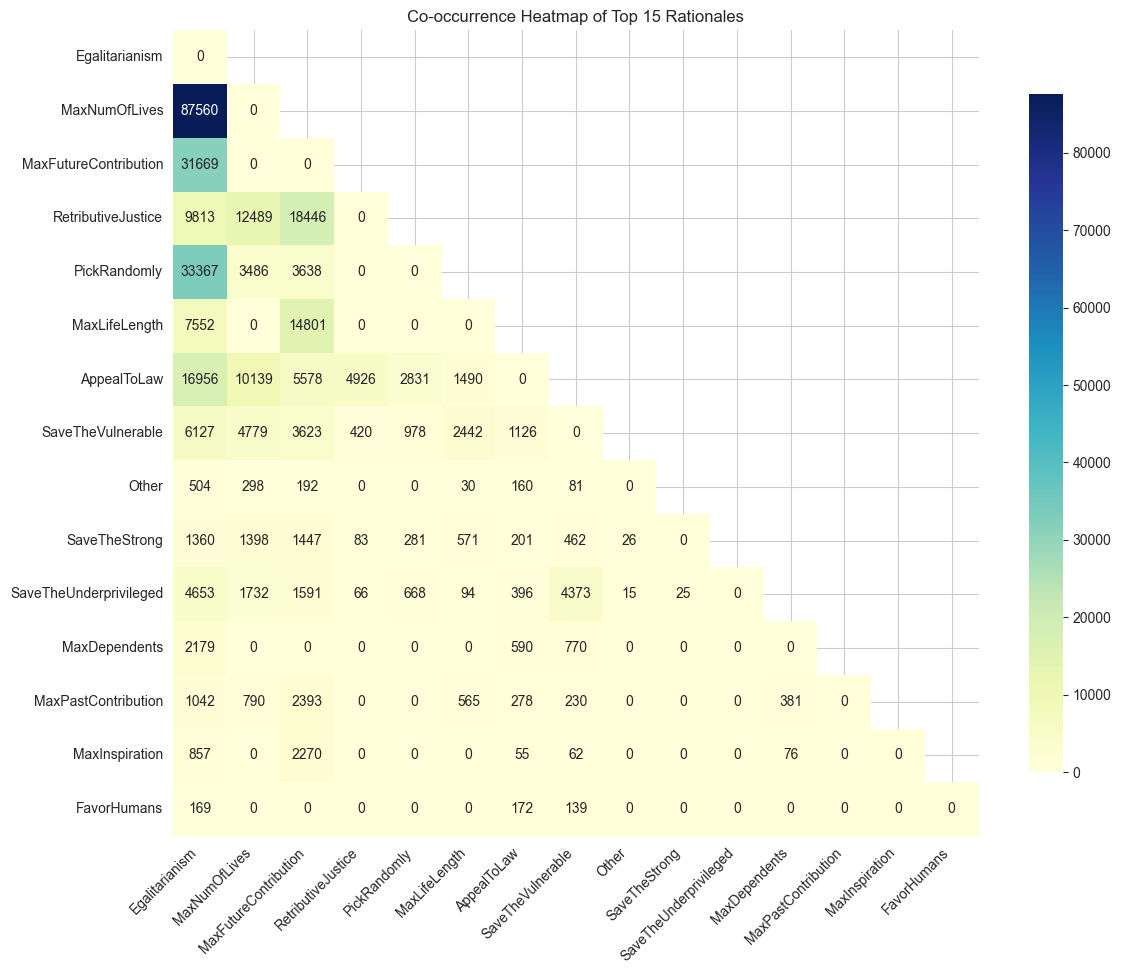

In [11]:
from collections import Counter
from itertools import combinations
import pandas as pd

original_responses_rationales = dfs[dfs['rationales'].ne('') & dfs['decision'].ne('')]['rationales'].apply(
    lambda L: sorted(list(set(r.strip() for r in L.split(';') if r.strip()))) # Unique rationales per response
)

cooccurrence_counts = Counter()
for r_list in original_responses_rationales:
    for r1, r2 in combinations(r_list, 2):
        # Ensure consistent order for pairs (e.g., alphabetical)
        pair = tuple(sorted((r1, r2)))
        cooccurrence_counts[pair] += 1

# Convert to DataFrame for heatmap
cooccurrence_df = pd.DataFrame.from_records(
    [(p[0], p[1], count) for p, count in cooccurrence_counts.items()],
    columns=['rationale1', 'rationale2', 'count']
)

# Select top N rationales to make the heatmap manageable
top_rationales_for_cooccurrence = df_rationales_exploded['individual_rationale'].value_counts().nlargest(15).index.tolist()

# Filter cooccurrence_df to include only pairs where both rationales are in the top N
cooccurrence_df_filtered = cooccurrence_df[
    cooccurrence_df['rationale1'].isin(top_rationales_for_cooccurrence) &
    cooccurrence_df['rationale2'].isin(top_rationales_for_cooccurrence)
]

cooccurrence_pivot = cooccurrence_df_filtered.pivot_table(
    index='rationale1', columns='rationale2', values='count', fill_value=0
)
# Make it symmetric
cooccurrence_pivot_full = cooccurrence_pivot.T.combine_first(cooccurrence_pivot).fillna(0)
# Ensure all top rationales are present as rows/columns
cooccurrence_pivot_full = cooccurrence_pivot_full.reindex(index=top_rationales_for_cooccurrence, columns=top_rationales_for_cooccurrence, fill_value=0)

mask = np.triu(np.ones_like(cooccurrence_pivot_full, dtype=bool), k=1)

plt.figure(figsize=(12, 10))
sns.heatmap(
    cooccurrence_pivot_full,
    mask=mask,
    annot=True,
    cmap="YlGnBu",
    fmt="g",
    square=True,
    cbar_kws={"shrink": .8}
)
plt.title('Co-occurrence Heatmap of Top 15 Rationales')
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

Analyzing choice set: 2 boys; an elderly man for phenomenon Age


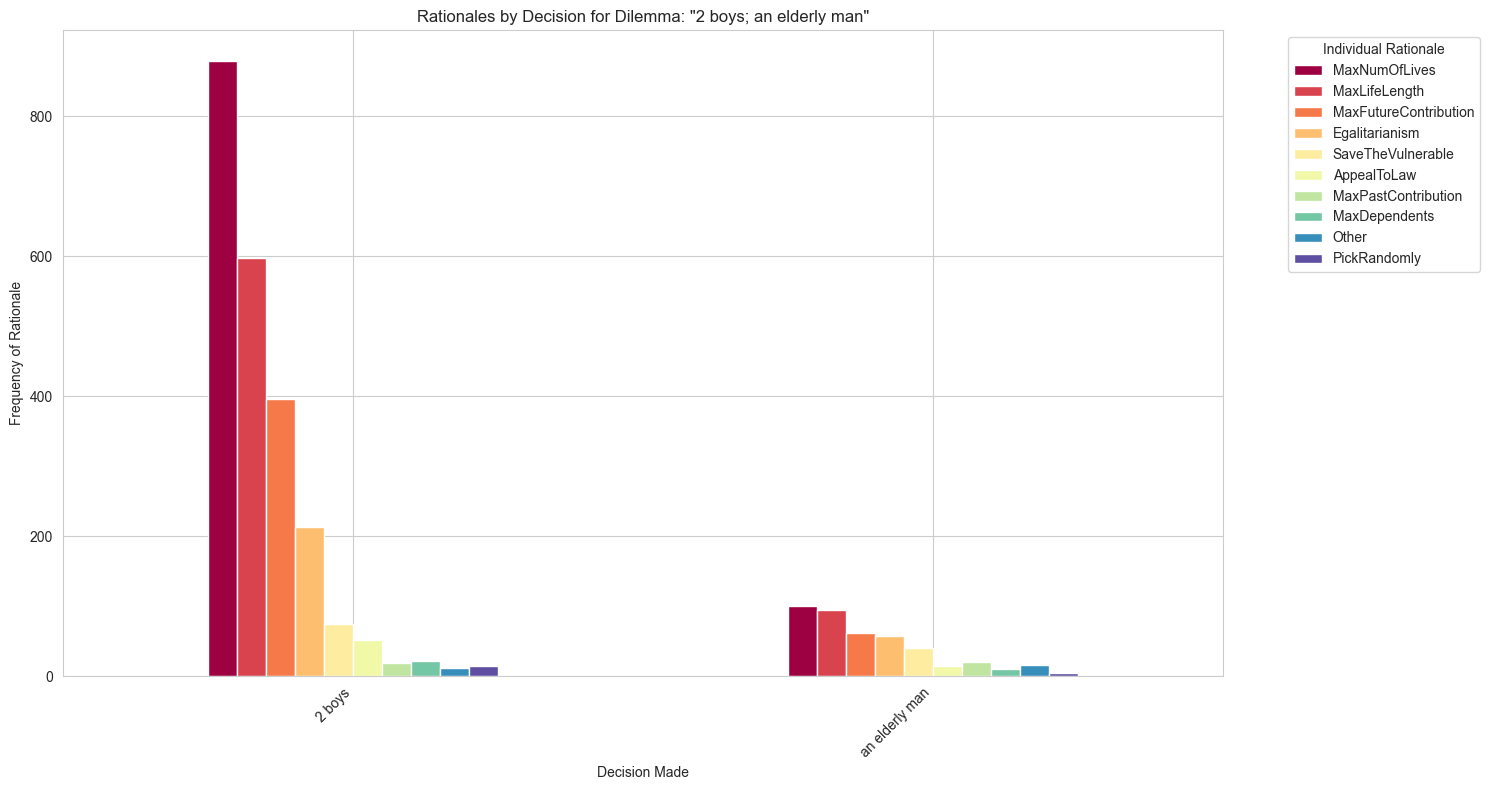

In [12]:
# Find a common two_choices_set
# For example, find one related to 'Age' phenomenon if available
example_phenomenon = 'Age'
if example_phenomenon in df_rationales_exploded['phenomenon_category'].unique():

    # Try to find a common choice set for this phenomenon
    choice_sets_for_phenom = df_rationales_exploded[
        df_rationales_exploded['phenomenon_category'] == example_phenomenon
    ]['two_choices_set'].value_counts()

    if not choice_sets_for_phenom.empty:
        example_choice_set = choice_sets_for_phenom.index[0]
        print(f"Analyzing choice set: {example_choice_set} for phenomenon {example_phenomenon}")

        df_subset = df_rationales_exploded[
            (df_rationales_exploded['two_choices_set'] == example_choice_set) &
            (df_rationales_exploded['phenomenon_category'] == example_phenomenon)
        ].copy() # .copy() to avoid SettingWithCopyWarning

        # Map decision to actual choice names for clarity if needed
        # For simplicity, we'll use decision as is, assuming it matches choice1 or choice2 from original dilemma
        # We need 'choice1' and 'choice2' at the exploded rationale level.
        # This requires merging them back or ensuring they are present.
        # Let's re-fetch 'choice1', 'choice2' from 'dfs' based on index for this subset.
        # Ensure the index of df_subset aligns with dfs if you directly map
        # For this example, we assume 'decision' column directly indicates the choice made.

        if not df_subset.empty:
            # Identify what choice1 and choice2 are for this specific two_choices_set
            # This is a bit tricky because choice1/choice2 can swap.
            # Let's use the 'decision_category' as a proxy for what was chosen,
            # or directly the 'decision' column if it contains the character's description.

            # Let's look at rationales associated with each unique decision value within this subset
            decision_rationale_counts = df_subset.groupby(['decision', 'individual_rationale']).size().unstack(fill_value=0)

            # We might want to see proportions
            # decision_rationale_prop = decision_rationale_counts.apply(lambda x: x / x.sum(), axis=1)

            # Select top N rationales overall for this subset to make the plot manageable
            top_n_rationales_subset = df_subset['individual_rationale'].value_counts().nlargest(10).index

            if not top_n_rationales_subset.empty:
                decision_rationale_counts_filtered = decision_rationale_counts[top_n_rationales_subset]

                if not decision_rationale_counts_filtered.empty:
                    decision_rationale_counts_filtered.plot(
                        kind='bar',
                        figsize=(15, 8),
                        colormap="Spectral"
                    )
                    plt.title(f'Rationales by Decision for Dilemma: "{example_choice_set}"')
                    plt.xlabel('Decision Made')
                    plt.ylabel('Frequency of Rationale')
                    plt.xticks(rotation=45, ha="right")
                    plt.legend(title='Individual Rationale', bbox_to_anchor=(1.05, 1), loc='upper left')
                    plt.tight_layout()
                    # plt.savefig(f"{FIGURE_SAVE_DIR}/rationales_by_decision_for_{example_phenomenon}.png")
                    plt.show()
                else:
                    print(f"No rationales to plot for decisions in choice set: {example_choice_set}")
            else:
                print(f"No top rationales found for subset: {example_choice_set}")

        else:
            print(f"No data for choice set: {example_choice_set} and phenomenon: {example_phenomenon}")
    else:
        print(f"No choice sets found for phenomenon: {example_phenomenon}")
else:
    print(f"Phenomenon '{example_phenomenon}' not found in data.")

In [15]:
import plotly.express as px

# explode rationales & map → fine + macro
df = (
    dfs.assign(response_id=lambda d: d.index)
       .assign(rationale=lambda d: d.rationales.str.split(';'))
       .explode('rationale')
       .assign(rationale=lambda s: s.rationale.str.strip())
       .assign(macro=lambda d: d.rationale.map(macro_map).fillna('Other'))
)

# count occurrences
counts = (
    df.groupby(['macro', 'rationale'])
      .size()
      .reset_index(name='count')
      .query('count > 5')          # drop one-offs for readability
)

fig = px.treemap(counts,
                 path=['macro', 'rationale'],
                 values='count',
                 color='macro',)
fig.update_layout(width=900, height=600)
fig.show()

In [59]:
macro_map

{'MaxDependents': 'Consequentialism',
 'MaxFutureContribution': 'Consequentialism',
 'MaxHope': 'Consequentialism',
 'MaxLifeLength': 'Consequentialism',
 'MaxNumOfLives': 'Consequentialism',
 'SaveTheStrong': 'Consequentialism',
 'MaxInspiration': 'Consequentialism',
 'MaxPastContribution': 'Consequentialism',
 'SaveTheUnderprivileged': 'Deontology',
 'Egalitarianism': 'Deontology',
 'SaveTheVulnerable': 'Deontology',
 'AnimalRights': 'Deontology',
 'PickRandomly': 'Deontology',
 'AppealToLaw': 'Deontology',
 'RetributiveJustice': 'Deontology',
 'FavorHumans': 'Deontology',
 'Other': 'Other'}

Pearson r: 0.328, p-value: 0.0135


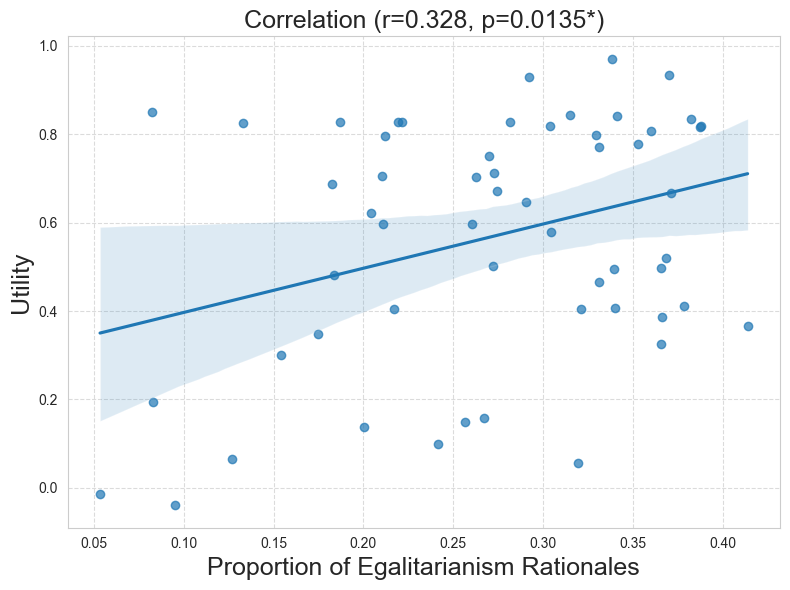

In [57]:
from scipy.stats import pearsonr
sns.set_style(style="whitegrid")

# Filter the dataframe as specified
filtered = df_rationales_exploded[
    (df_rationales_exploded['reasoning_first'] == True) &
    (df_rationales_exploded['equal_group_size'] == False) &
    (df_rationales_exploded['reasoning_model'] == False) &
    (df_rationales_exploded['model_type'] == 'final')
]

# Calculate proportion of MaxNumOfLives rationales per model
rationale_counts = (
    filtered.groupby('model_name')['individual_rationale']
    .value_counts(normalize=True)
    .unstack(fill_value=0)
)

rationale_to_examine = (
    # 'MaxNumOfLives'
    # 'MaxLifeLength'
    # 'MaxFutureContribution'
    # 'SaveTheVulnerable'
    # 'SaveTheUnderprivileged'
    'Egalitarianism'
)

prop_maxnum = rationale_counts[rationale_to_examine]

# Calculate average decision_utility per model
avg_utility = (
    filtered.groupby('model_name')['decision_utility']
    .mean()
)

# Combine into a single DataFrame
summary = pd.DataFrame({
    'prop_rationale': prop_maxnum,
    'avg_decision_utility': avg_utility
}).dropna()

# Compute correlation
r, p = pearsonr(summary['prop_rationale'], summary['avg_decision_utility'])
print(f"Pearson r: {r:.3f}, p-value: {p:.3g}")

# Plot
fig, ax = plt.subplots(figsize=(8, 6))

# Create regression plot
sns.regplot(
    x='prop_rationale',
    y='avg_decision_utility',
    data=summary,
    scatter_kws={'alpha': 0.7},
    # line_kws={'color': 'b'},
    ax=ax
)

# Add model labels to points
# for model, row in summary.iterrows():
#     ax.text(row['prop_rationale'] + 0.005, row['avg_decision_utility'], model,
#             fontsize=8, alpha=0.7, ha='left', va='center')

ax.set_xlabel(f'Proportion of {rationale_to_examine} Rationales', fontsize=18)
ax.set_ylabel('Utility', fontsize=18)
ax.set_title(f'Correlation (r={r:.3f}, p={p:.3g}{p_to_stars(p)})', fontsize=18)
ax.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

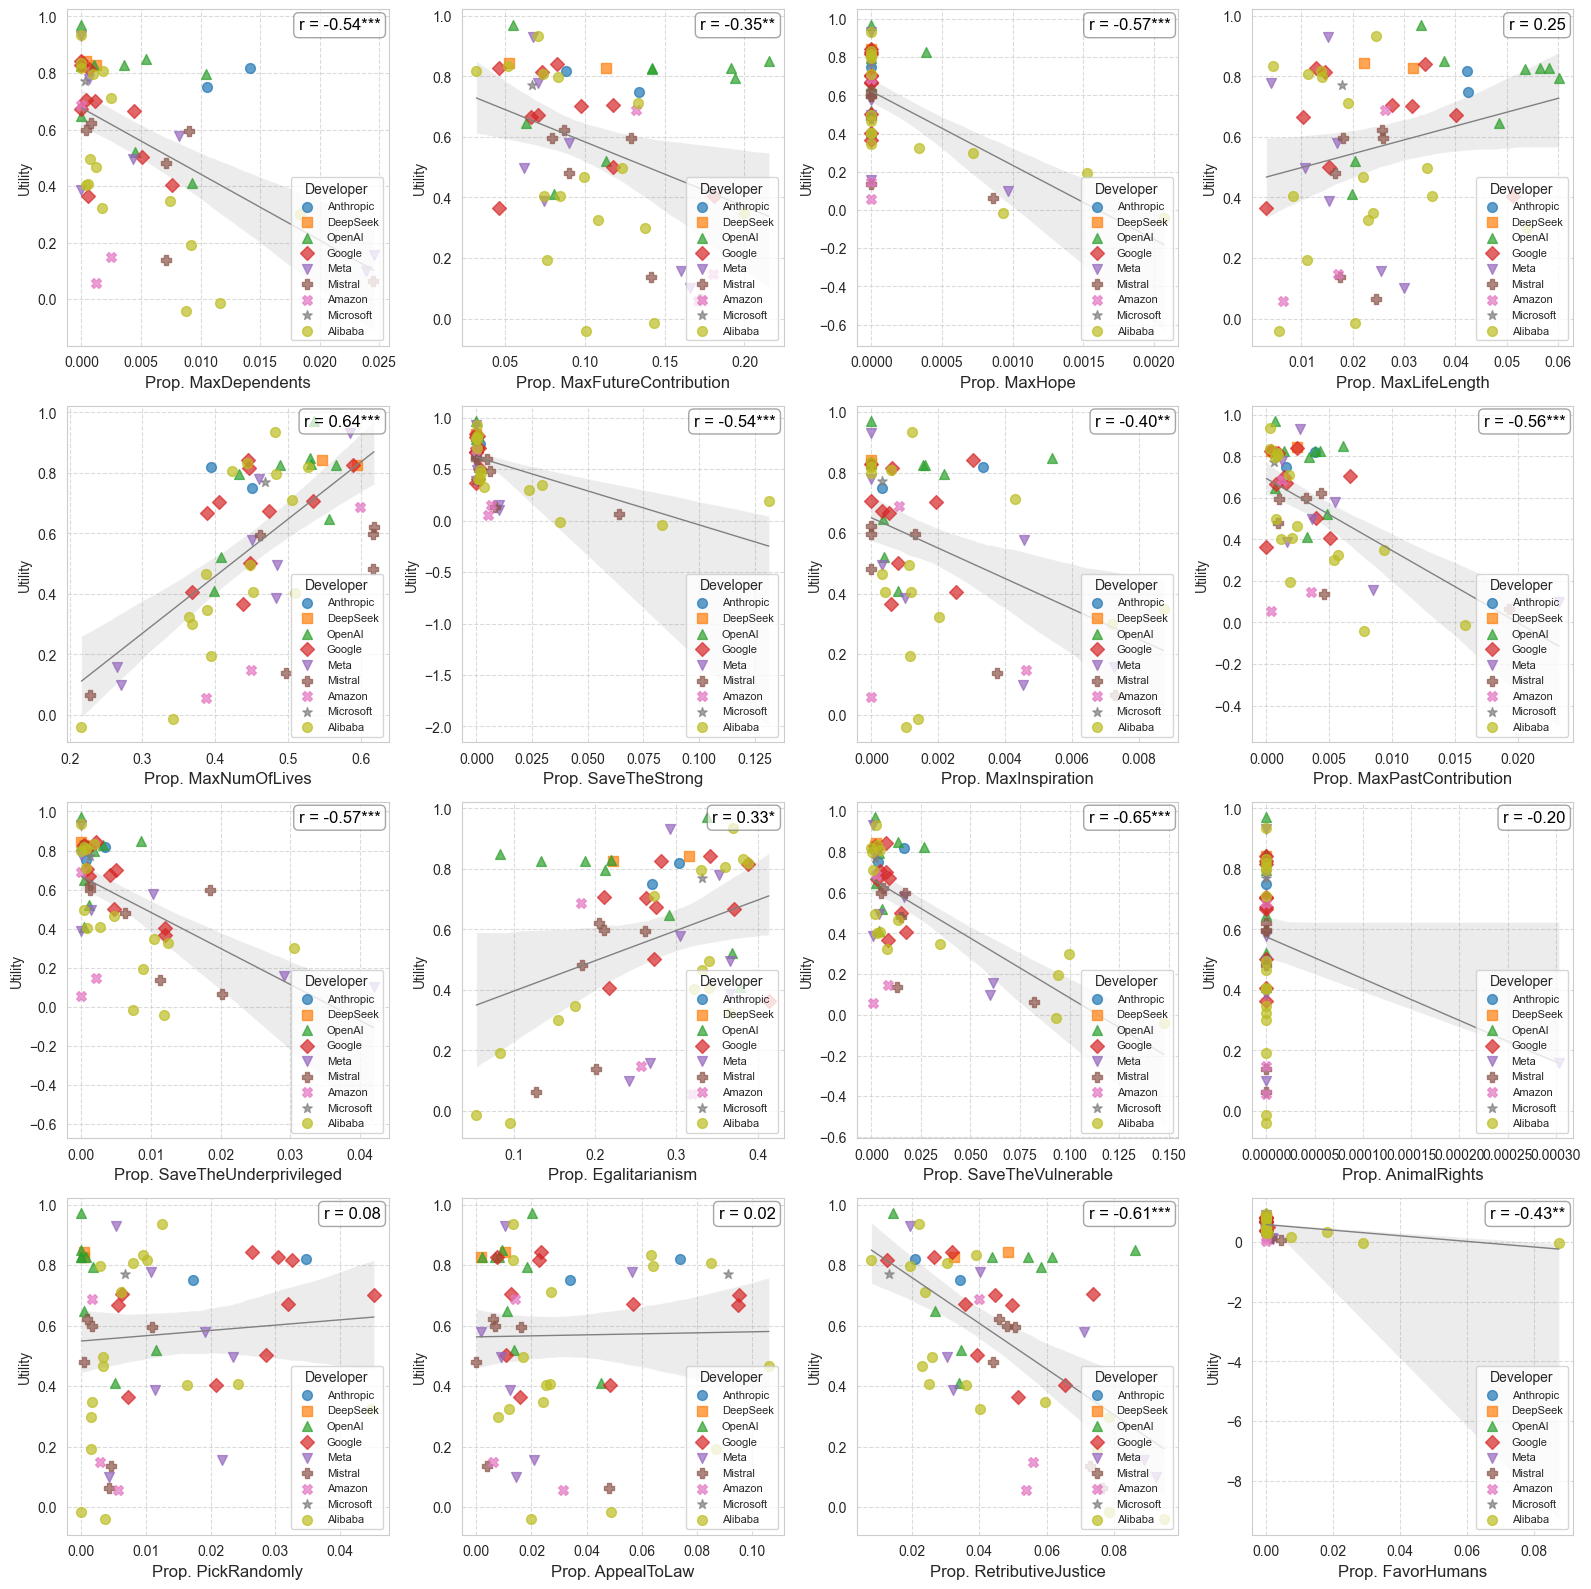

In [130]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

# Filter the dataframe as specified
filtered = df_rationales_exploded[
    (df_rationales_exploded['reasoning_first'] == True) &
    (df_rationales_exploded['equal_group_size'] == False) &
    (df_rationales_exploded['reasoning_model'] == False) &
    (df_rationales_exploded['model_type'] == 'final')
]

# your macro_map defined elsewhere
rationales = [r for r in macro_map.keys() if r != 'Other']

# fixed positions dict
fixed_positions = {
    "top_right":    (0.975, 0.975, "top",    "right"),
    "top_left":     (0.025, 0.975, "top",    "left"),
    "bottom_right": (0.975, 0.025, "bottom", "right"),
    "bottom_left":  (0.025, 0.025, "bottom", "left"),
}

def p_to_stars(p):
    if p < 0.001:
        return '***'
    elif p < 0.01:
        return '**'
    elif p < 0.05:
        return '*'
    else:
        return ''

# precompute a mapping from model_name → developer
dev_map = filtered.groupby('model_name')['developer'].first()

# get distinct developers
developers = dev_map.unique()
n_dev = len(developers)

# choose a palette + markers
palette = sns.color_palette("tab10", n_colors=n_dev)
markers = ['o', 's', '^', 'D', 'v', 'P', 'X', '*']  # extend if more than 8

dev2color = {dev: palette[i] for i, dev in enumerate(developers)}
dev2marker = {dev: markers[i % len(markers)] for i, dev in enumerate(developers)}

sns.set_style("whitegrid")
fig, axes = plt.subplots(4, 4, figsize=(16, 16))
axes = axes.flatten()

for ax, rationale in zip(axes, rationales):
    # --- compute proportions & mean utility per model ---
    counts = (
        filtered.groupby('model_name')['individual_rationale']
        .value_counts(normalize=True)
        .unstack(fill_value=0)
    )
    prop = counts.get(rationale, pd.Series(0, index=counts.index))
    avg_util = filtered.groupby('model_name')['decision_utility'].mean()
    summary = pd.DataFrame({
        'prop_rationale': prop,
        'avg_decision_utility': avg_util
    }).dropna()

    # bring in developer
    summary['developer'] = dev_map.reindex(summary.index)

    # compute correlation
    r_val, p_val = pearsonr(summary['prop_rationale'], summary['avg_decision_utility'])
    stars_corr = p_to_stars(p_val)

    # plot the overall regression line (no scatter)
    sns.regplot(
        x='prop_rationale', y='avg_decision_utility',
        data=summary,
        scatter=False,
        line_kws={'lw':1, 'color':'gray'},
        ax=ax
    )

    # now plot each developer’s points
    for dev in developers:
        sub = summary[summary['developer'] == dev]
        ax.scatter(
            sub['prop_rationale'],
            sub['avg_decision_utility'],
            label=dev,
            alpha=0.7,
            s=50,
            c=[dev2color[dev]],
            marker=dev2marker[dev]
        )

    # annotation
    txt = f"r = {r_val:.2f}{stars_corr}"
    cx, cy, va, ha = fixed_positions["top_right"]
    ax.text(
        cx, cy, txt,
        transform=ax.transAxes,
        fontsize=12,
        va=va, ha=ha,
        color='black',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.7, edgecolor='gray')
    )

    # labels
    ax.set_xlabel(f'Prop. {rationale}', fontsize=12)
    ax.set_ylabel('Utility', fontsize=10)
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.legend(frameon=True, fontsize=8, title='Developer', loc='lower right',)

# remove any extra axes
for i in range(len(rationales), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

In [139]:
sns.color_palette("colorblind")

[(0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
 (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
 (0.8352941176470589, 0.3686274509803922, 0.0),
 (0.8, 0.47058823529411764, 0.7372549019607844),
 (0.792156862745098, 0.5686274509803921, 0.3803921568627451),
 (0.984313725490196, 0.6862745098039216, 0.8941176470588236),
 (0.5803921568627451, 0.5803921568627451, 0.5803921568627451),
 (0.9254901960784314, 0.8823529411764706, 0.2),
 (0.33725490196078434, 0.7058823529411765, 0.9137254901960784)]

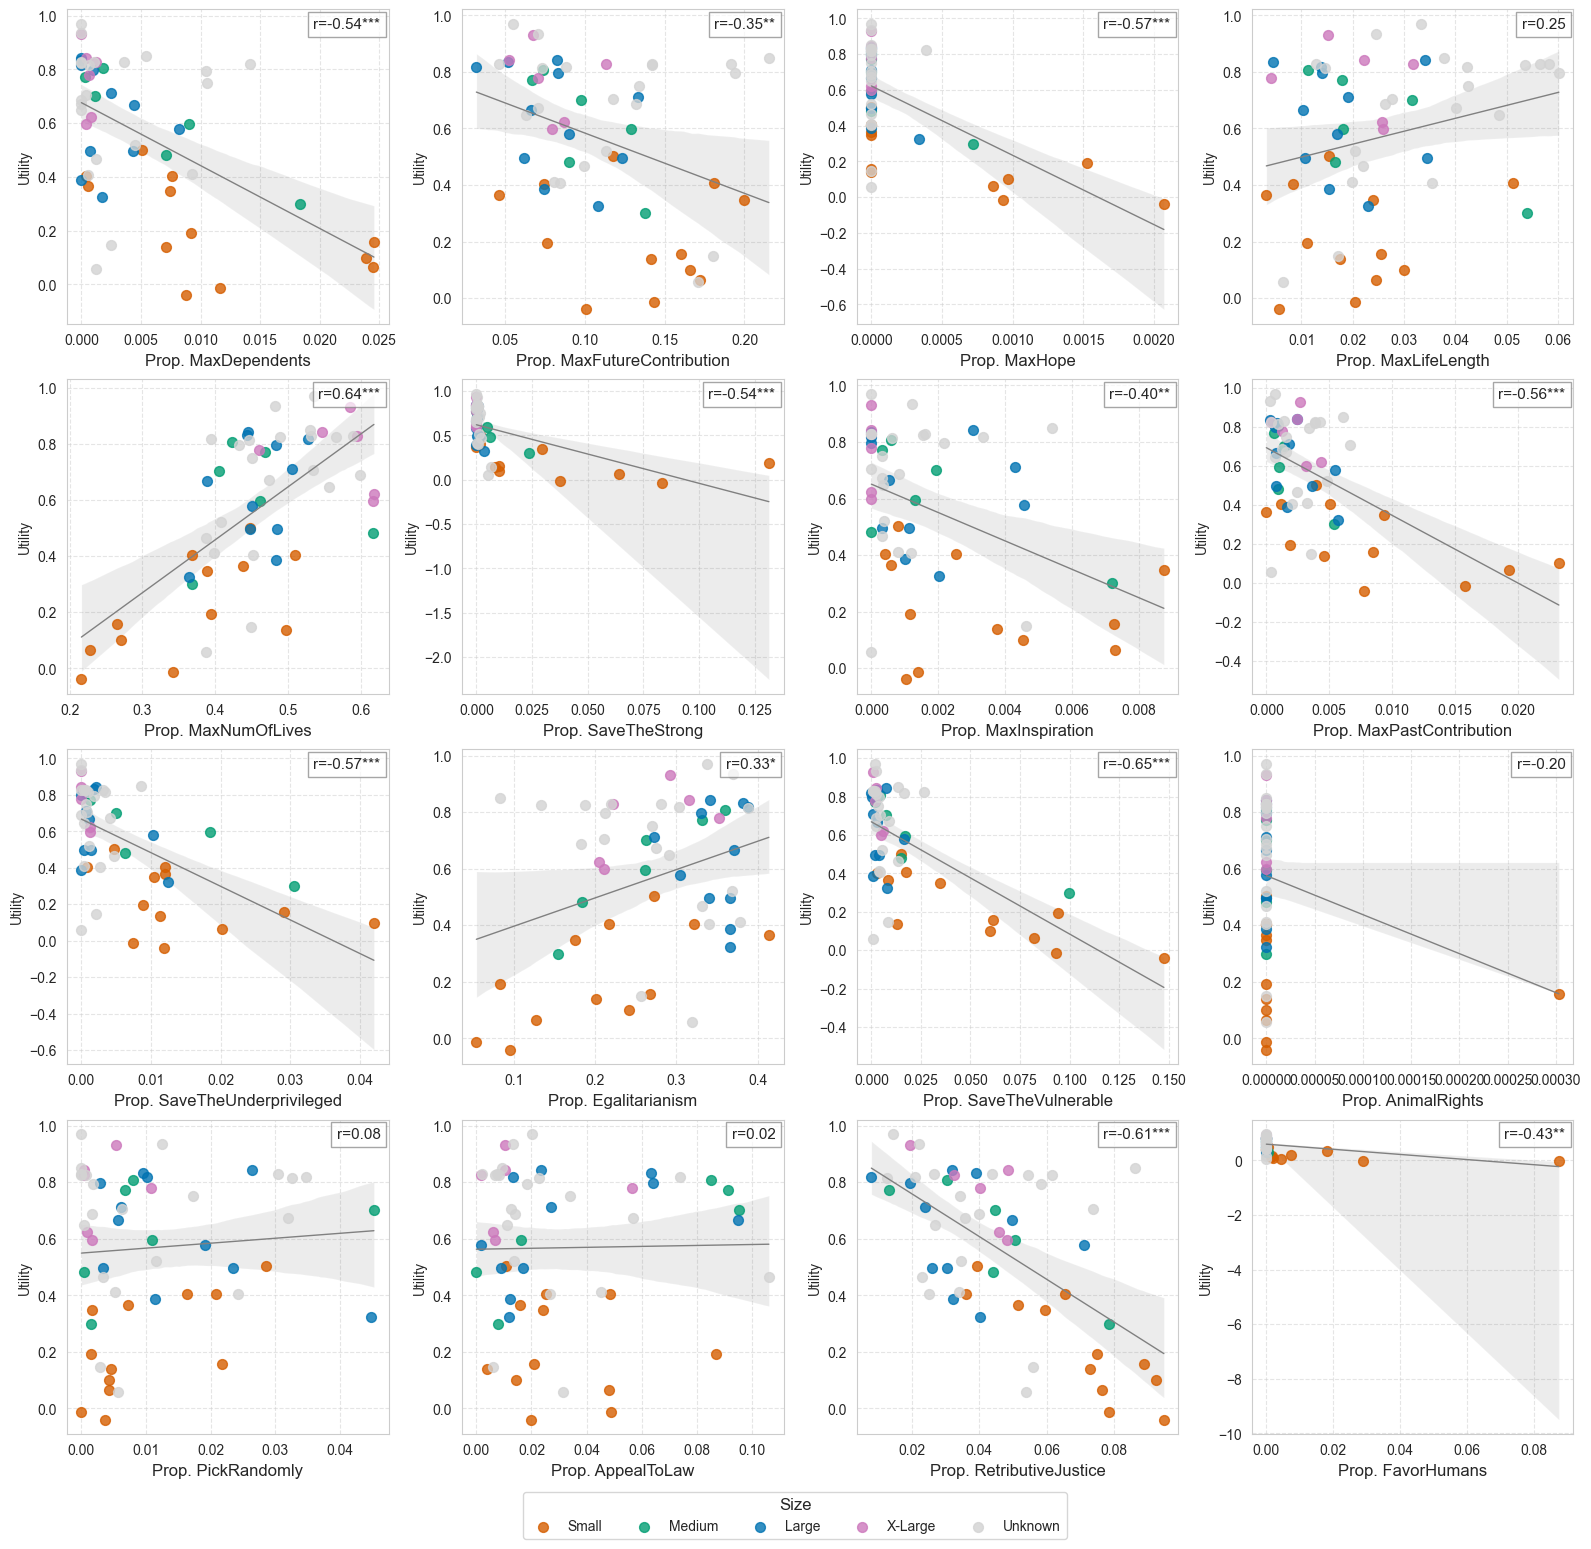

In [158]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
import numpy as np
import pandas as pd  # make sure pandas is imported

# same filtering as before
filtered = df_rationales_exploded[
    (df_rationales_exploded['reasoning_first'] == True) &
    (df_rationales_exploded['equal_group_size'] == False) &
    (df_rationales_exploded['reasoning_model'] == False) &
    (df_rationales_exploded['model_type'] == 'final')
]

# list of rationales
rationales = [r for r in macro_map.keys() if r != 'Other']

# grab each model's first-seen parameter count (if any)
param_map = filtered.groupby('model_name')['parameter_count'].first()

# define a simple binning function
def bin_size(n):
    if pd.isna(n):
        return 'Unknown'
    elif n <= 10:    # up to 100M
        return 'Small'
    elif n <= 25:    # up to 1B
        return 'Medium'
    elif n <= 100:   # up to 10B
        return 'Large'
    else:
        return 'X-Large'

# map every model to a size category
size_cat = param_map.map(bin_size)

# get the colorblind palette (first four colors)
cb = sns.color_palette("colorblind")

cat_colors = {
    'Small':   cb[3],        # blue-ish
    'Medium':  cb[2],        # orange-ish
    'Large':   cb[0],        # green-ish
    'X-Large': cb[4],        # red-ish
    'Unknown': 'lightgray'   # keep gray for missing
}

# ordering for legend
categories = ['Small', 'Medium', 'Large', 'X-Large', 'Unknown']

sns.set_style("whitegrid")
fig, axes = plt.subplots(4, 4, figsize=(16, 16))
axes = axes.flatten()

# we'll collect one proxy artist per category for the shared legend
proxy_handles = []
proxy_labels = []

for ax, rationale in zip(axes, rationales):
    # build summary per model
    counts = (
        filtered.groupby('model_name')['individual_rationale']
        .value_counts(normalize=True)
        .unstack(fill_value=0)
    )
    prop = counts.get(rationale, pd.Series(0, index=counts.index))
    avg_util = filtered.groupby('model_name')['decision_utility'].mean()
    summary = pd.DataFrame({
        'prop_rationale': prop,
        'avg_decision_utility': avg_util
    }).dropna()

    # bring in size category
    summary['size_cat'] = size_cat.reindex(summary.index).fillna('Unknown')

    # overall regression
    sns.regplot(
        x='prop_rationale', y='avg_decision_utility',
        data=summary, scatter=False,
        line_kws={'lw':1, 'color':'gray'},
        ax=ax
    )

    # scatter by category
    for cat in categories:
        sub = summary[summary['size_cat'] == cat]
        if not sub.empty:
            sc = ax.scatter(
                sub['prop_rationale'],
                sub['avg_decision_utility'],
                label=cat,
                alpha=0.8,
                s=50,
                c=[cat_colors[cat]],
                marker='o',
            )
            # only add one proxy per category
            if cat not in proxy_labels:
                proxy_handles.append(sc)
                proxy_labels.append(cat)

    # annotation of correlation
    r_val, p_val = pearsonr(summary['prop_rationale'], summary['avg_decision_utility'])
    stars = p_to_stars(p_val)
    ax.text(
        0.975, 0.975, f"r={r_val:.2f}{stars}",
        transform=ax.transAxes,
        va='top', ha='right',
        fontsize=11,
        bbox=dict(facecolor='white', edgecolor='gray', alpha=0.7)
    )

    ax.set_xlabel(f'Prop. {rationale}', fontsize=12)
    ax.set_ylabel('Utility', fontsize=10)
    ax.grid(True, linestyle='--', alpha=0.5)
    # remove per‐axes legend
    ax.legend_.remove() if ax.get_legend() else None

# drop extra axes
for i in range(len(rationales), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()

# add shared legend below
fig.legend(
    handles=proxy_handles,
    labels=proxy_labels,
    title='Size',
    loc='lower center',
    ncols=5,
    frameon=True,
    fontsize=10,
    title_fontsize=12,
    bbox_to_anchor=(0.5, 0.03)
)

# adjust bottom margin to make room
plt.subplots_adjust(bottom=0.1)

plt.show()

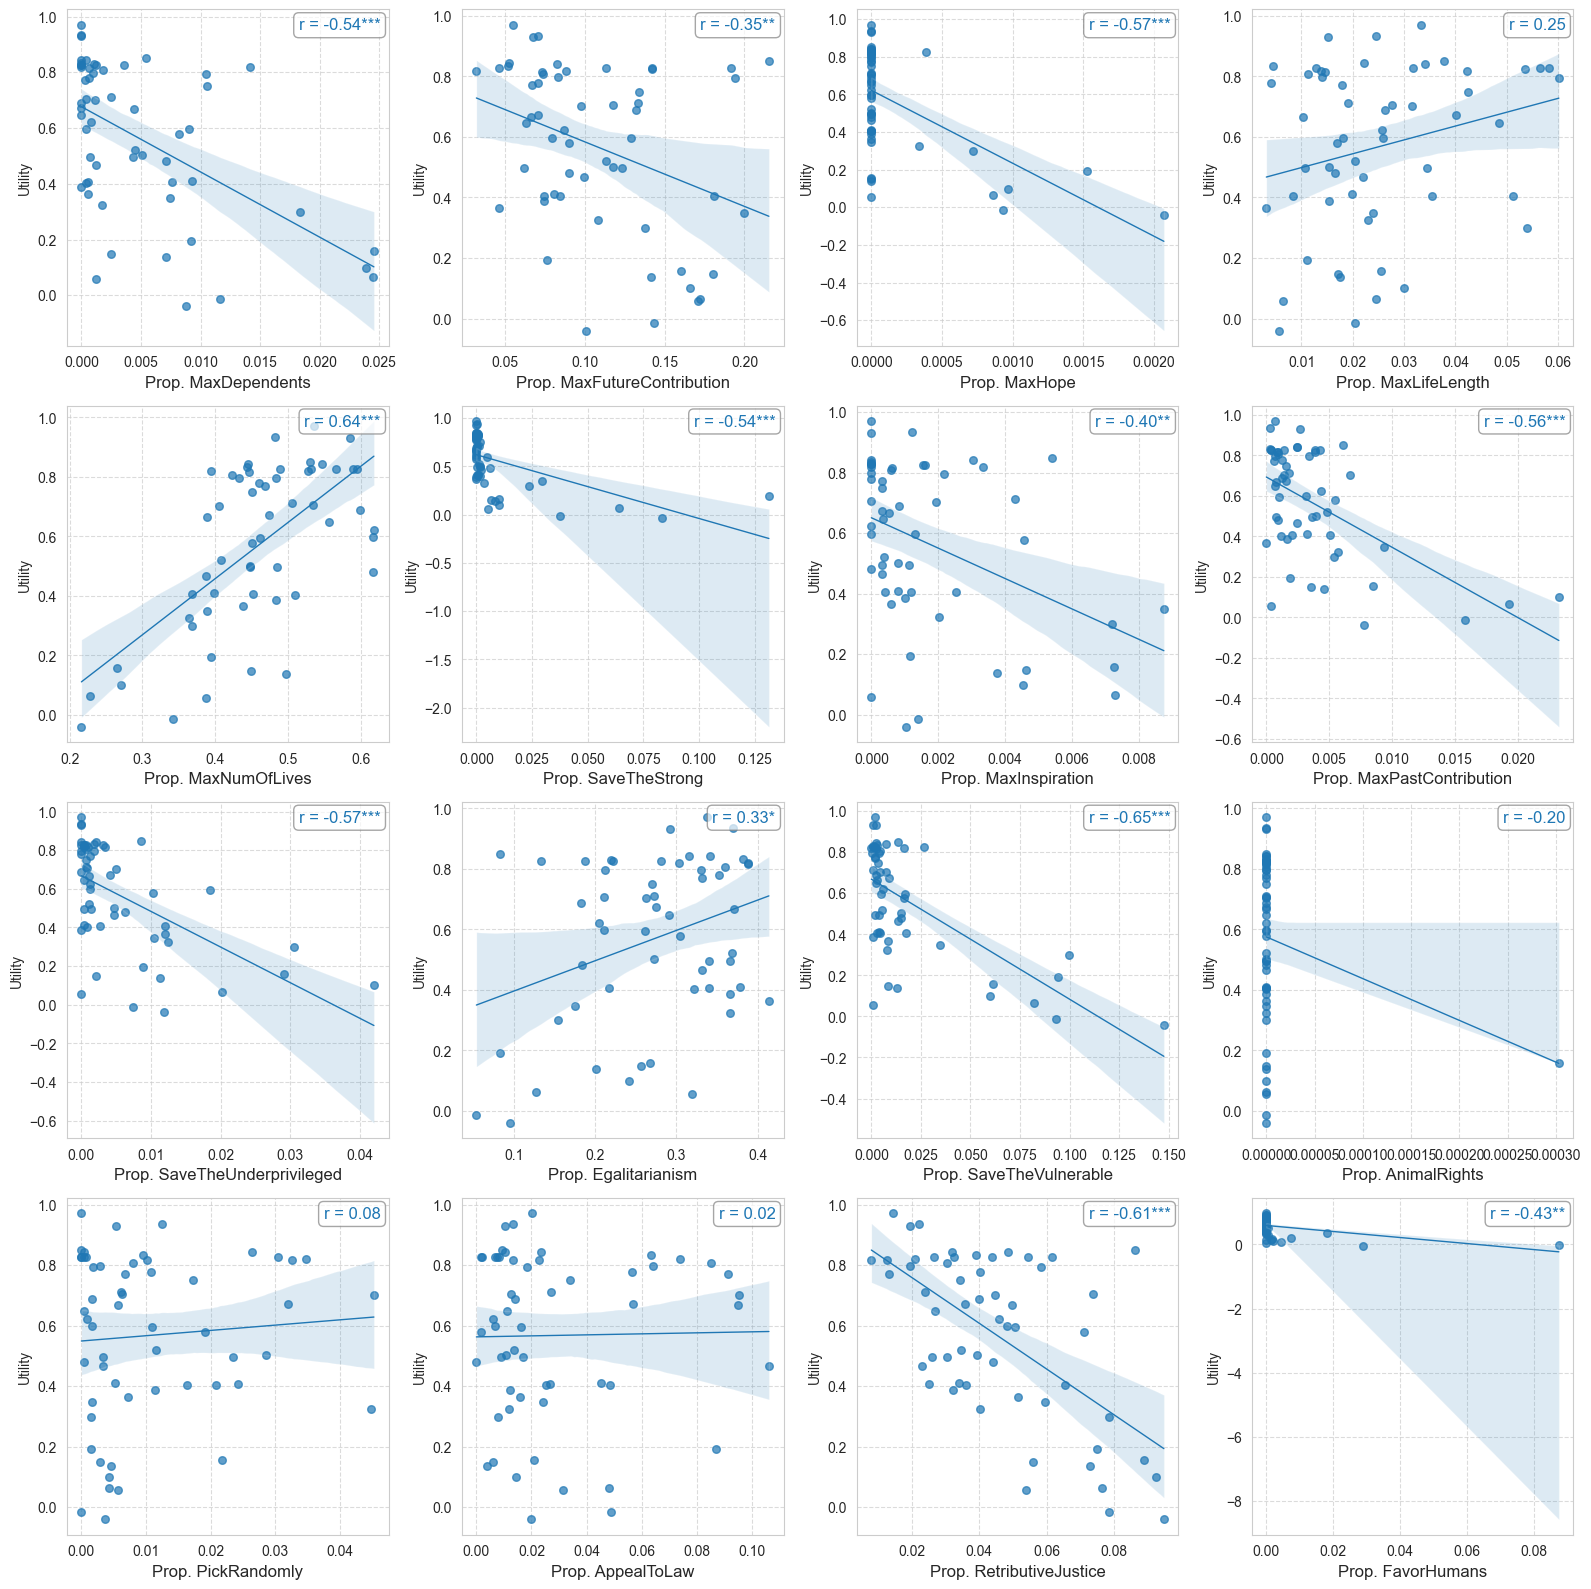

In [80]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

# Filter the dataframe as specified
filtered = df_rationales_exploded[
    (df_rationales_exploded['reasoning_first'] == True) &
    (df_rationales_exploded['equal_group_size'] == False) &
    (df_rationales_exploded['reasoning_model'] == False) &
    (df_rationales_exploded['model_type'] == 'final')
]

# your macro_map defined elsewhere
rationales = [r for r in macro_map.keys() if r != 'Other']

# fixed positions dict
fixed_positions = {
    "top_right":    (0.975, 0.975, "top",    "right"),
    "top_left":     (0.025, 0.975, "top",    "left"),
    "bottom_right": (0.975, 0.025, "bottom", "right"),
    "bottom_left":  (0.025, 0.025, "bottom", "left"),
}

def p_to_stars(p):
    if p < 0.001:
        return '***'
    elif p < 0.01:
        return '**'
    elif p < 0.05:
        return '*'
    else:
        return ''

sns.set_style("whitegrid")
fig, axes = plt.subplots(4, 4, figsize=(16, 16))
axes = axes.flatten()

for ax, rationale in zip(axes, rationales):
    # compute proportions & mean utility
    counts = (
        filtered.groupby('model_name')['individual_rationale']
        .value_counts(normalize=True)
        .unstack(fill_value=0)
    )
    prop = counts[rationale]
    avg_util = filtered.groupby('model_name')['decision_utility'].mean()
    summary = pd.DataFrame({
        'prop_rationale': prop,
        'avg_decision_utility': avg_util
    }).dropna()

    # compute correlation
    r_val, p_val = pearsonr(summary['prop_rationale'], summary['avg_decision_utility'])
    stars_corr = p_to_stars(p_val)

    # plot regression
    sns.regplot(
        x='prop_rationale', y='avg_decision_utility',
        data=summary, scatter_kws={'alpha':0.7,'s':30},
        line_kws={'lw':1}, ax=ax
    )

    # annotation
    txt = f"r = {r_val:.2f}{stars_corr}"
    cx, cy, va, ha = fixed_positions["top_right"]
    ax.text(
        cx, cy, txt,
        transform=ax.transAxes,
        fontsize=12,
        va=va, ha=ha,
        color=sns.color_palette("tab10")[0],
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.7, edgecolor='gray')
    )

    # labels
    # ax.set_title(rationale, fontsize=12)
    ax.set_xlabel(f'Prop. {rationale}', fontsize=12)
    ax.set_ylabel('Utility', fontsize=10)
    ax.grid(True, linestyle='--', alpha=0.7)

# remove any extra axes
for i in range(len(rationales), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

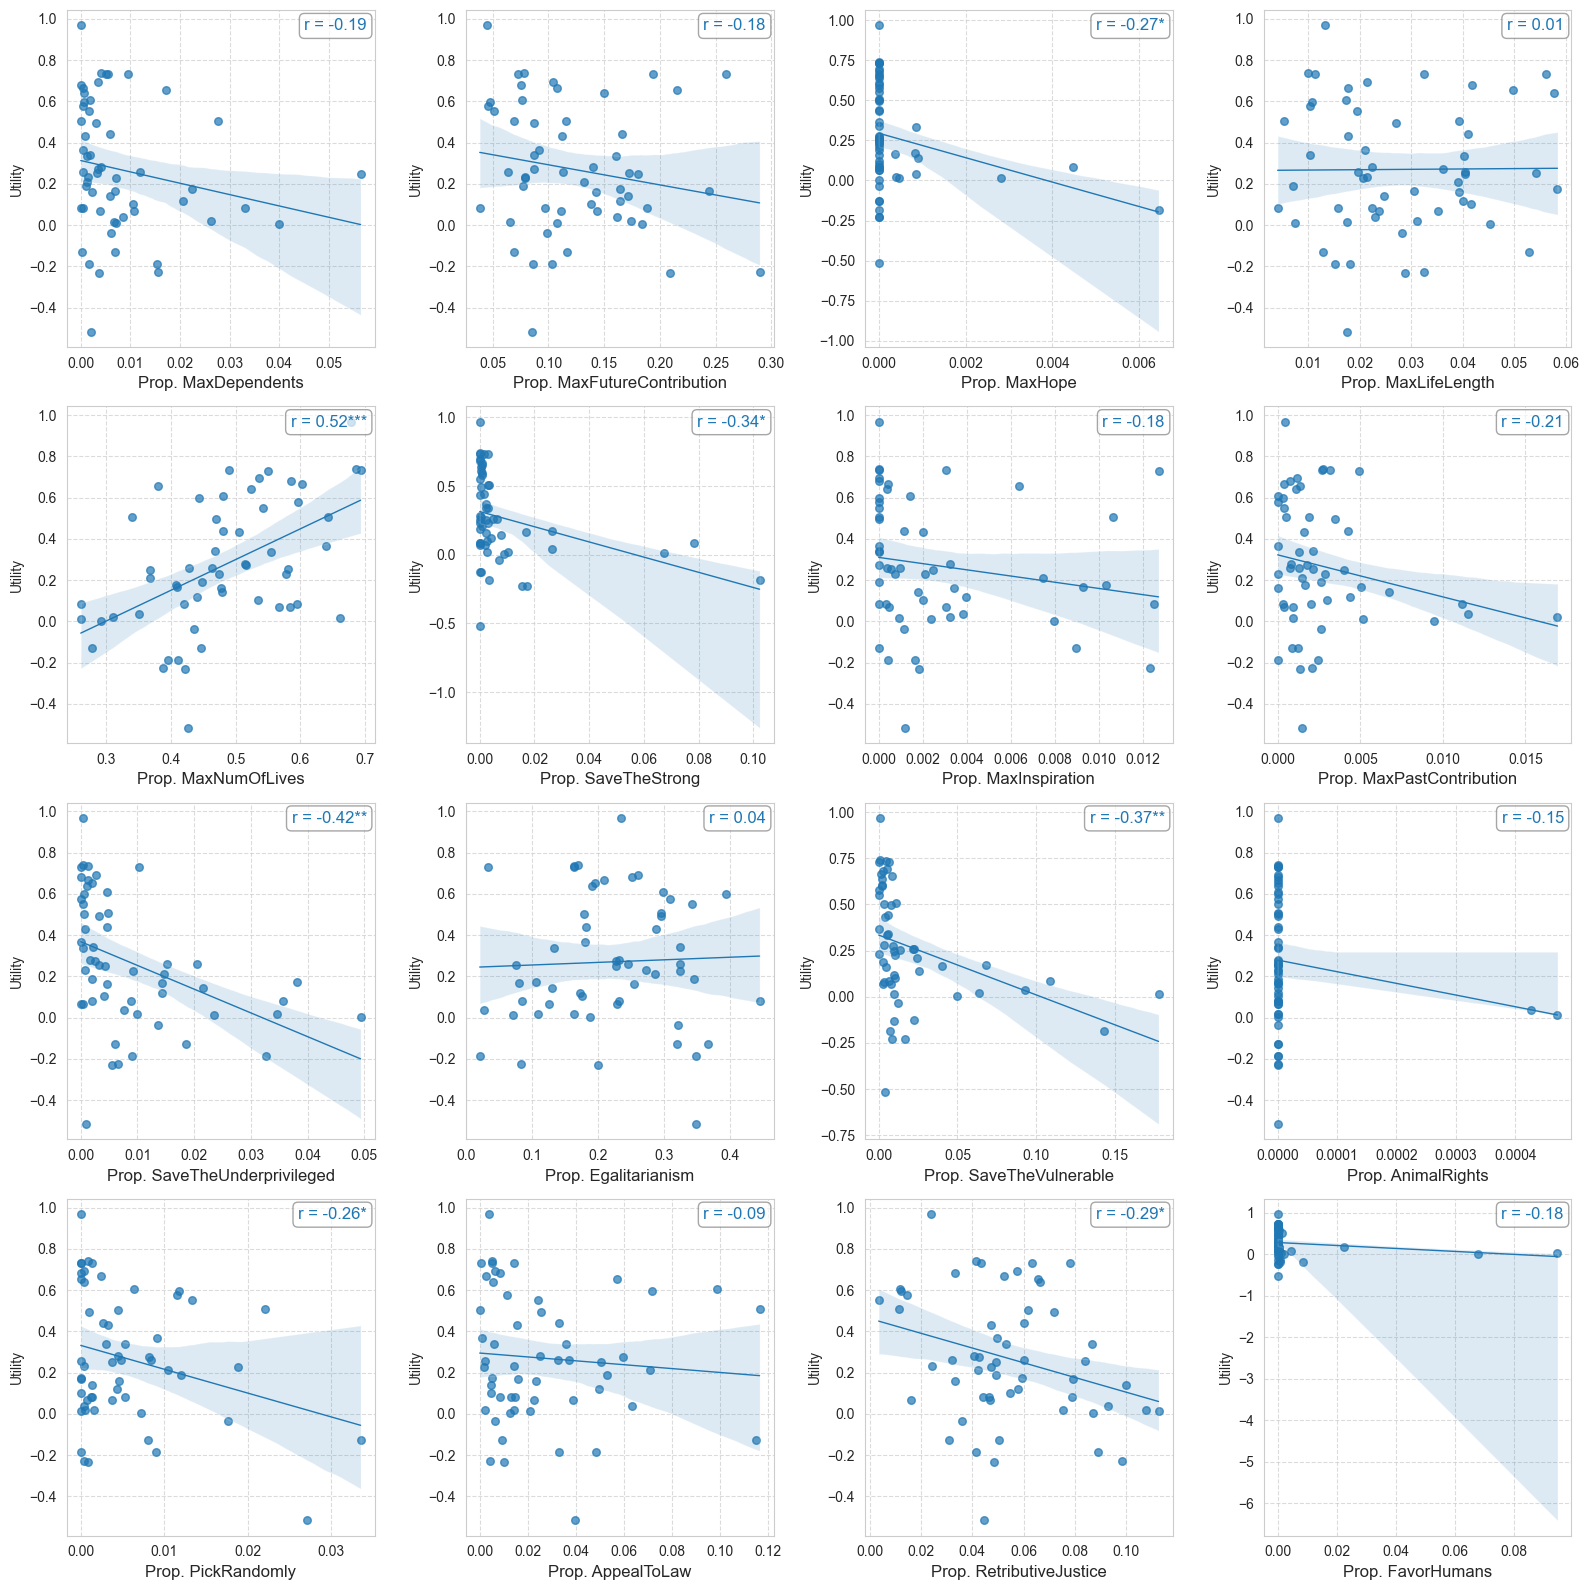

In [91]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

# Filter the dataframe as specified
filtered = df_rationales_exploded[
    (df_rationales_exploded['reasoning_first'] == False) &
    (df_rationales_exploded['equal_group_size'] == False) &
    (df_rationales_exploded['reasoning_model'] == False) &
    (df_rationales_exploded['model_type'] == 'final')
]

# your macro_map defined elsewhere
rationales = [r for r in macro_map.keys() if r != 'Other']

# fixed positions dict
fixed_positions = {
    "top_right":    (0.975, 0.975, "top",    "right"),
    "top_left":     (0.025, 0.975, "top",    "left"),
    "bottom_right": (0.975, 0.025, "bottom", "right"),
    "bottom_left":  (0.025, 0.025, "bottom", "left"),
}

def p_to_stars(p):
    if p < 0.001:
        return '***'
    elif p < 0.01:
        return '**'
    elif p < 0.05:
        return '*'
    else:
        return ''

sns.set_style("whitegrid")
fig, axes = plt.subplots(4, 4, figsize=(16, 16))
axes = axes.flatten()

for ax, rationale in zip(axes, rationales):
    # compute proportions & mean utility
    counts = (
        filtered.groupby('model_name')['individual_rationale']
        .value_counts(normalize=True)
        .unstack(fill_value=0)
    )
    prop = counts[rationale]
    avg_util = filtered.groupby('model_name')['decision_utility'].mean()
    summary = pd.DataFrame({
        'prop_rationale': prop,
        'avg_decision_utility': avg_util
    }).dropna()

    # compute correlation
    r_val, p_val = pearsonr(summary['prop_rationale'], summary['avg_decision_utility'])
    stars_corr = p_to_stars(p_val)

    # plot regression
    sns.regplot(
        x='prop_rationale', y='avg_decision_utility',
        data=summary, scatter_kws={'alpha':0.7,'s':30},
        line_kws={'lw':1}, ax=ax
    )

    # annotation
    txt = f"r = {r_val:.2f}{stars_corr}"
    cx, cy, va, ha = fixed_positions["top_right"]
    ax.text(
        cx, cy, txt,
        transform=ax.transAxes,
        fontsize=12,
        va=va, ha=ha,
        color=sns.color_palette("tab10")[0],
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.7, edgecolor='gray')
    )

    # labels
    # ax.set_title(rationale, fontsize=12)
    ax.set_xlabel(f'Prop. {rationale}', fontsize=12)
    ax.set_ylabel('Utility', fontsize=10)
    ax.grid(True, linestyle='--', alpha=0.7)

# remove any extra axes
for i in range(len(rationales), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

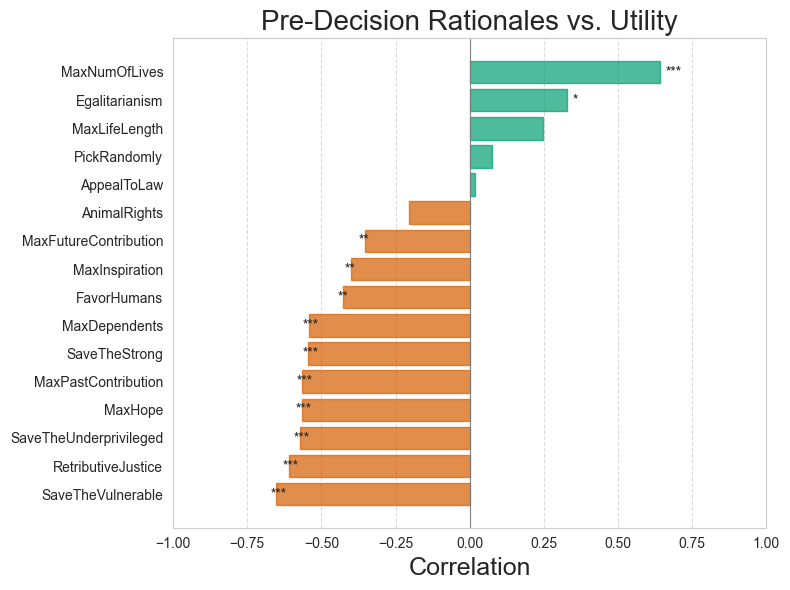

In [108]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# Filter the dataframe as specified
filtered = df_rationales_exploded[
    (df_rationales_exploded['reasoning_first'] == True) &
    (df_rationales_exploded['equal_group_size'] == False) &
    (df_rationales_exploded['reasoning_model'] == False) &
    (df_rationales_exploded['model_type'] == 'final')
]

# your macro_map defined elsewhere
rationales = [r for r in macro_map.keys() if r != 'Other']

# 1) Gather correlations
corrs = []
for rationale in rationales:
    counts = (
        filtered.groupby('model_name')['individual_rationale']
        .value_counts(normalize=True)
        .unstack(fill_value=0)
    )
    prop = counts[rationale]
    avg_util = filtered.groupby('model_name')['decision_utility'].mean()
    summary = pd.DataFrame({
        'prop_rationale': prop,
        'avg_decision_utility': avg_util
    }).dropna()
    r_val, p_val = pearsonr(summary['prop_rationale'], summary['avg_decision_utility'])
    corrs.append((rationale, r_val, p_val))

corr_df = pd.DataFrame(corrs, columns=['rationale','r','p'])
corr_df['stars'] = corr_df['p'].apply(p_to_stars)
corr_df = corr_df.sort_values('r')

# 2) Plot bar‐chart
fig, ax = plt.subplots(figsize=(8, 6))
# Use a colorblind-friendly palette
colors = sns.color_palette("colorblind")
bars = ax.barh(corr_df['rationale'], corr_df['r'], alpha=0.7)
# 3) Color by sign
for i, bar in enumerate(bars):
    if bar.get_width() > 0:
        bar.set_color(colors[2])  # Green-ish in the colorblind palette
    else:
        bar.set_color(colors[3])  # Red-ish in the colorblind palette
# 4) Annotate stars
for y, (_, r, stars) in enumerate(zip(corr_df['rationale'], corr_df['r'], corr_df['stars'])):
    if stars:
        ax.text(r + 0.02 * (1 if r>0 else -1), y, stars, va='center')

ax.grid()
ax.grid(axis='x', linestyle='--', alpha=0.7)
ax.axvline(0, color='gray', linewidth=0.8)
ax.set_xlabel("Correlation", fontsize=18)
ax.set_title("Pre-Decision Rationales vs. Utility", fontsize=20)
ax.set_xlim(-1, 1)
plt.tight_layout()
plt.show()

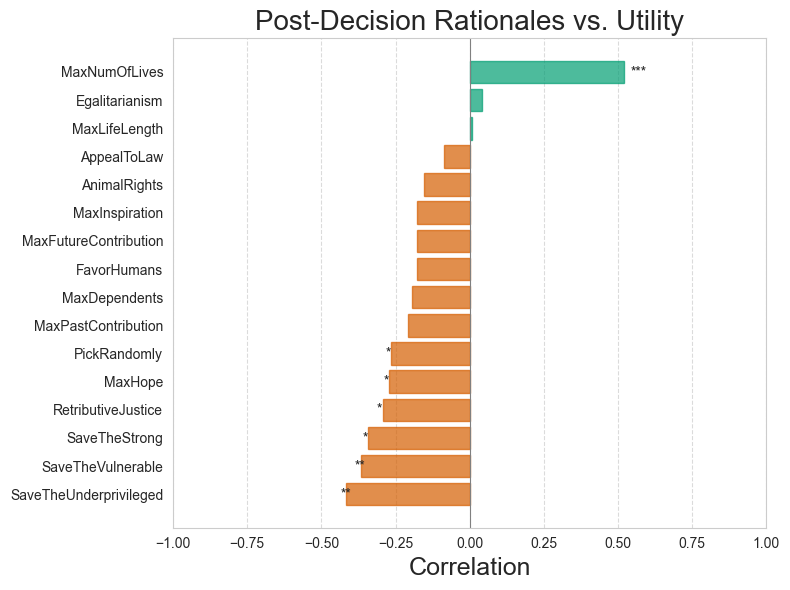

In [109]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# Filter the dataframe as specified
filtered = df_rationales_exploded[
    (df_rationales_exploded['reasoning_first'] == False) &
    (df_rationales_exploded['equal_group_size'] == False) &
    (df_rationales_exploded['reasoning_model'] == False) &
    (df_rationales_exploded['model_type'] == 'final')
]

# your macro_map defined elsewhere
rationales = [r for r in macro_map.keys() if r != 'Other']

# 1) Gather correlations
corrs = []
for rationale in rationales:
    counts = (
        filtered.groupby('model_name')['individual_rationale']
        .value_counts(normalize=True)
        .unstack(fill_value=0)
    )
    prop = counts[rationale]
    avg_util = filtered.groupby('model_name')['decision_utility'].mean()
    summary = pd.DataFrame({
        'prop_rationale': prop,
        'avg_decision_utility': avg_util
    }).dropna()
    r_val, p_val = pearsonr(summary['prop_rationale'], summary['avg_decision_utility'])
    corrs.append((rationale, r_val, p_val))

corr_df = pd.DataFrame(corrs, columns=['rationale','r','p'])
corr_df['stars'] = corr_df['p'].apply(p_to_stars)
corr_df = corr_df.sort_values('r')

# 2) Plot bar‐chart
fig, ax = plt.subplots(figsize=(8, 6))
# Use a colorblind-friendly palette
colors = sns.color_palette("colorblind")
bars = ax.barh(corr_df['rationale'], corr_df['r'], alpha=0.7)
# 3) Color by sign
for i, bar in enumerate(bars):
    if bar.get_width() > 0:
        bar.set_color(colors[2])  # Green-ish in the colorblind palette
    else:
        bar.set_color(colors[3])  # Red-ish in the colorblind palette
# 4) Annotate stars
for y, (_, r, stars) in enumerate(zip(corr_df['rationale'], corr_df['r'], corr_df['stars'])):
    if stars:
        ax.text(r + 0.02 * (1 if r>0 else -1), y, stars, va='center')

ax.grid()
ax.grid(axis='x', linestyle='--', alpha=0.7)
ax.axvline(0, color='gray', linewidth=0.8)
ax.set_xlabel("Correlation", fontsize=18)
ax.set_title("Post-Decision Rationales vs. Utility", fontsize=20)
ax.set_xlim(-1, 1)
plt.tight_layout()
plt.show()

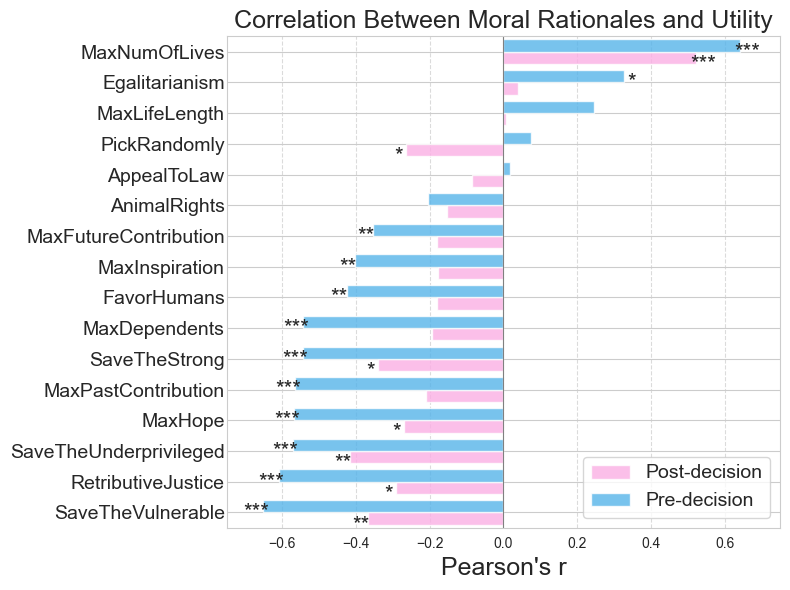

In [200]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

def compute_corr(filtered):
    corrs = []
    # same macro_map / rationales as before
    rationales = [r for r in macro_map.keys() if r != 'Other']
    for rationale in rationales:
        counts = (
            filtered.groupby('model_name')['individual_rationale']
            .value_counts(normalize=True)
            .unstack(fill_value=0)
        )
        prop = counts[rationale]
        avg_util = filtered.groupby('model_name')['decision_utility'].mean()
        summary = pd.DataFrame({
            'prop_rationale': prop,
            'avg_decision_utility': avg_util
        }).dropna()
        r_val, p_val = pearsonr(summary['prop_rationale'], summary['avg_decision_utility'])
        corrs.append((rationale, r_val, p_val))
    df = pd.DataFrame(corrs, columns=['rationale','r','p'])
    df['stars'] = df['p'].apply(p_to_stars)
    return df.sort_values('r')

# 1) split by reasoning_first
base_filter = (
    (df_rationales_exploded['equal_group_size'] == False) &
    (df_rationales_exploded['reasoning_model'] == False) &
    (df_rationales_exploded['model_type'] == 'final')
)

df_false = df_rationales_exploded[ base_filter & (df_rationales_exploded['reasoning_first']==False) ]
df_true  = df_rationales_exploded[ base_filter & (df_rationales_exploded['reasoning_first']==True ) ]

corr_false = compute_corr(df_false)
corr_true  = compute_corr(df_true)

# align them on the same index order
rationales = corr_true['rationale'].tolist()
r_false    = corr_false.set_index('rationale').loc[rationales, 'r'].values
stars_false= corr_false.set_index('rationale').loc[rationales, 'stars'].values
r_true     = corr_true .set_index('rationale').loc[rationales, 'r'].values
stars_true = corr_true .set_index('rationale').loc[rationales, 'stars'].values

# 2) grouped barh
y = np.arange(len(rationales))
height = 0.4

fig, ax = plt.subplots(figsize=(8, 6))
# pick colorblind‐safe
pal = sns.color_palette("colorblind")
bar1 = ax.barh(y - height/2, r_false, height, color=pal[6], alpha=0.8, label='Post-decision')
bar2 = ax.barh(y + height/2, r_true,  height, color=pal[-1], alpha=0.8, label='Pre-decision')

# zero line
ax.axvline(0, color='gray', lw=0.8)

# y‐ticks
ax.set_yticks(y)
ax.set_yticklabels(rationales, fontsize=14)

# x‐axis
ax.set_xlabel("Pearson's r", fontsize=18)
ax.set_xlim(-0.75, 0.75)
ax.grid(axis='x', linestyle='--', alpha=0.7)

# stars annotations
for i, (r, s) in enumerate(zip(r_false, stars_false)):
    if s:
        x = r + 0.02 * np.sign(r if r!=0 else 1)
        ax.text(x, y[i] - height, s, va='center', ha='center', fontsize=16)
for i, (r, s) in enumerate(zip(r_true, stars_true)):
    if s:
        x = r + 0.02 * np.sign(r if r!=0 else 1)
        ax.text(x, y[i] , s, va='center', ha='center', fontsize=16)

# legend & title
ax.legend(frameon=True, fontsize=14, loc='lower right')
ax.set_title("Correlation Between Moral Rationales and Utility", fontsize=18)
ax.set_ylim(-0.5, len(y) - 0.5)
ax.tick_params(axis='y', pad=-2)

plt.tight_layout()
plt.savefig(f"{FIGURE_SAVE_DIR}/bar_correlation_rationalesAndUtility__reasoningOrder.pdf", dpi=300)
plt.show()

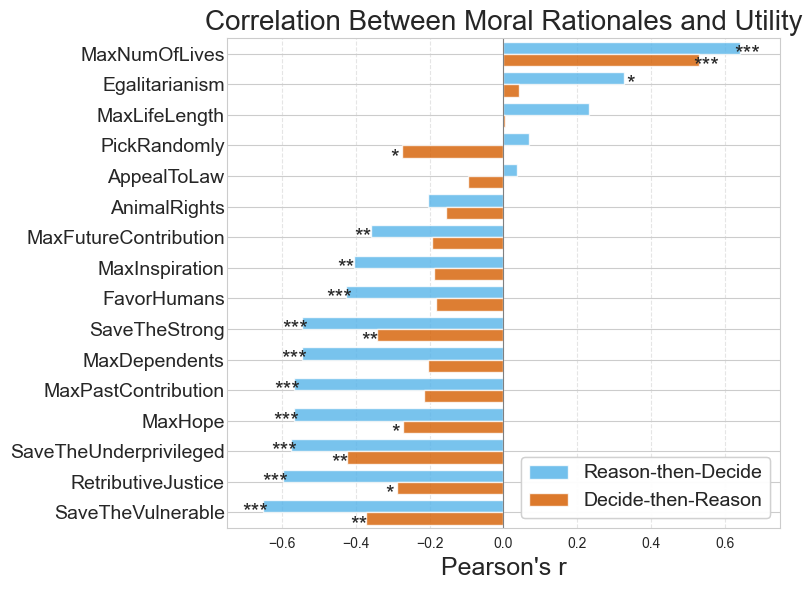

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, t

def compute_corr(filtered):
    corrs = []
    rationales = [r for r in macro_map.keys() if r != 'Other']
    for rationale in rationales:
        counts = (
            filtered.groupby('model_name')['individual_rationale']
            .value_counts(normalize=True)
            .unstack(fill_value=0)
        )
        prop = counts[rationale]
        avg_util = filtered.groupby('model_name')['decision_utility'].mean()
        summary = pd.DataFrame({
            'prop_rationale': prop,
            'avg_decision_utility': avg_util
        }).dropna()
        r_val, p_val = pearsonr(summary['prop_rationale'], summary['avg_decision_utility'])
        corrs.append((rationale, r_val, p_val, len(summary)))
    df = pd.DataFrame(corrs, columns=['rationale','r','p','N'])
    df['stars'] = df['p'].apply(p_to_stars)
    return df.sort_values('r')

# 1) split by reasoning_first
base_filter = (
    (df_rationales_exploded['equal_group_size'] == False) &
    (df_rationales_exploded['reasoning_model'] == False) &
    (df_rationales_exploded['model_type'] == 'final')
)

df_false = df_rationales_exploded[ base_filter & (df_rationales_exploded['reasoning_first']==False) ]
df_true  = df_rationales_exploded[ base_filter & (df_rationales_exploded['reasoning_first']==True ) ]

# filter & compute as before…
corr_false = compute_corr(df_false)
corr_true  = compute_corr(df_true)

# align
rationales  = corr_true['rationale'].tolist()
r_false     = corr_false.set_index('rationale').loc[rationales, 'r']
r_true      = corr_true .set_index('rationale').loc[rationales, 'r']
stars_false = corr_false.set_index('rationale').loc[rationales, 'stars']
stars_true  = corr_true .set_index('rationale').loc[rationales, 'stars']

# N & df
N_models = int(corr_true['N'].iloc[0])
dfree    = N_models - 2

def r_crit(alpha):
    tcrit = t.ppf(1 - alpha/2, dfree)
    return tcrit / np.sqrt(tcrit**2 + dfree)

r05, r01, r001 = r_crit(0.05), r_crit(0.01), r_crit(0.001)

# --- plotting ---
y = np.arange(len(rationales))
h = 0.4
fig, ax = plt.subplots(figsize=(8,6))
pal = sns.color_palette("colorblind")

# 1) shaded background bands
alpha = 1.0
# ax.axvspan(-r05, r05,   color='#ffcccc', alpha=alpha, zorder=0)  # darkest for p>0.05
# ax.axvspan(-r01, -r05,  color='#ffdddd', alpha=alpha, zorder=0)  # mid for 0.01<p<=0.05
# ax.axvspan(r05, r01,    color='#ffdddd', alpha=alpha, zorder=0)
# ax.axvspan(-r001, -r01, color='#ffeeee', alpha=alpha, zorder=0)  # light for 0.001<p<=0.01
# ax.axvspan(r01, r001,   color='#ffeeee', alpha=alpha, zorder=0)

# 2) bars
ax.barh(y + h/2, r_true,  height=h, color=pal[-1], alpha=0.8, label='Reason-then-Decide')
ax.barh(y - h/2, r_false, height=h, color=pal[3], alpha=0.8, label='Decide-then-Reason')

# 3) axes styling
ax.axvline(0, color='gray', lw=0.8)
ax.set_yticks(y)
ax.set_yticklabels(rationales, fontsize=14)
ax.set_xlabel("Pearson's r", fontsize=18)
ax.set_xlim(-0.75, 0.75)
ax.grid(axis='x', linestyle='--', alpha=0.5)
ax.set_title("Correlation Between Moral Rationales and Utility", fontsize=20)
ax.set_ylim(-0.5, len(y)-0.5)
ax.tick_params(axis='y', pad=-2)

# 4) stars
for i, (r, s) in enumerate(zip(r_false, stars_false)):
    if s:
        x = r + 0.02 * np.sign(r if r!=0 else 1)
        ax.text(x, y[i] - h, s, va='center', ha='center', fontsize=16)
for i, (r, s) in enumerate(zip(r_true, stars_true)):
    if s:
        x = r + 0.02 * np.sign(r if r!=0 else 1)
        ax.text(x, y[i], s, va='center', ha='center', fontsize=16)

# 5) first legend for bars
legend1 = ax.legend(frameon=True, fontsize=14, loc='lower right')

# 6) custom handles for significance bands
# handles2 = [
#     Patch(facecolor='#ffcccc', edgecolor='none', label='p > 0.05'),
#     Patch(facecolor='#ffdddd', edgecolor='none', label='p > 0.01'),
#     Patch(facecolor='#ffeeee', edgecolor='none', label='p > 0.001'),
# ]
# legend2 = ax.legend(handles=handles2, title="Significance", fontsize=14, title_fontsize=14,
#                     loc='lower right', frameon=True)

# 7) re‐add the first legend (since calling legend a second time replaces it)
ax.add_artist(legend1)

# 5) legend (only for bars + custom handles if you want)
# ax.legend(frameon=True, fontsize=14, loc='lower right')
plt.tight_layout()
plt.savefig(f"{FIGURE_SAVE_DIR}/bar_rationales_corr_with_utility.pdf", bbox_inches='tight', dpi=300)
plt.show()

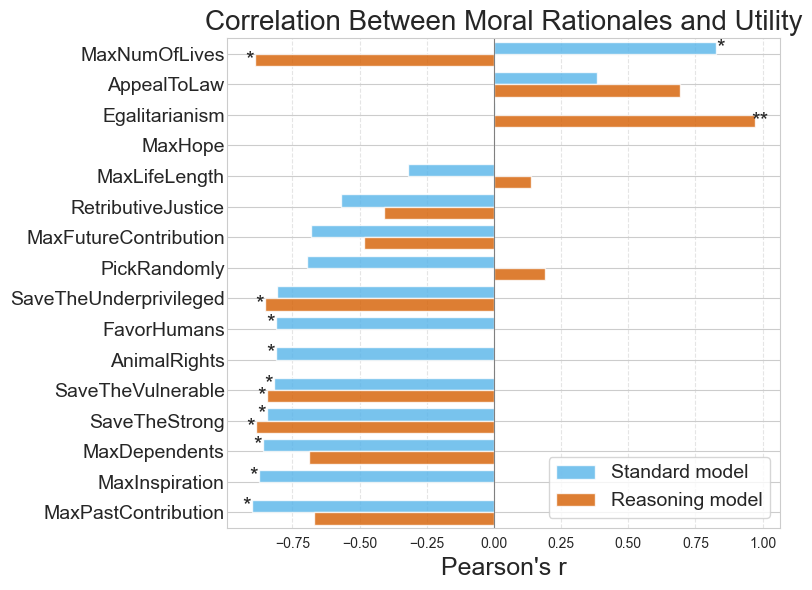

In [41]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, t
from matplotlib.patches import Patch        # only needed if you later re-enable the p-bands legend

# -------------------------------------------------------------------
# 1) robust correlation helper
# -------------------------------------------------------------------
def compute_corr(filtered):
    """Return a DataFrame with r, p, N and stars for every macro rationale.

    • If a rationale is missing from *filtered*, returns r=0, p=1, N=0
      so downstream code never hits a KeyError.
    • If fewer than two points are available the correlation is undefined;
      we treat that the same way (r=0, p=1).
    """
    corrs = []
    rationales = [r for r in macro_map.keys() if r != 'Other']

    # prepare once outside loop for speed
    counts = (
        filtered.groupby('model_name')['individual_rationale']
        .value_counts(normalize=True)
        .unstack(fill_value=0)
    )
    avg_util = filtered.groupby('model_name')['decision_utility'].mean()

    for rationale in rationales:
        if rationale not in counts.columns:
            corrs.append((rationale, 0.0, 1.0, 0))
            continue

        summary = pd.DataFrame({
            'prop_rationale': counts[rationale],
            'avg_decision_utility': avg_util
        }).dropna()

        if len(summary) < 2:
            corrs.append((rationale, 0.0, 1.0, len(summary)))
            continue

        r_val, p_val = pearsonr(summary['prop_rationale'],
                                summary['avg_decision_utility'])
        corrs.append((rationale, r_val, p_val, len(summary)))

    df = pd.DataFrame(corrs, columns=['rationale', 'r', 'p', 'N'])
    df['stars'] = df['p'].apply(p_to_stars)
    return df.sort_values('r')


# -------------------------------------------------------------------
# 2) slice the data – **standard vs reasoning model**
# -------------------------------------------------------------------
base_models = df_rationales_exploded[df_rationales_exploded['reasoning_model'] == True].dropna().model_base.unique()

base_filter = (
    (df_rationales_exploded['equal_group_size'] == False) &
    (df_rationales_exploded['model_type'] == 'final') &
    (df_rationales_exploded['reasoning_first'] == True) &
    (df_rationales_exploded['model_base'].isin(base_models))
)

df_standard  = df_rationales_exploded[ base_filter & (df_rationales_exploded['reasoning_model'] == False) ]
df_reasoning = df_rationales_exploded[ base_filter & (df_rationales_exploded['reasoning_model'] == True) ]

# correlations
corr_standard  = compute_corr(df_standard)
corr_reasoning = compute_corr(df_reasoning)

# -------------------------------------------------------------------
# 3) align the tables – guarantee every rationale is present
# -------------------------------------------------------------------
rationales = [r for r in macro_map.keys() if r != 'Other']   # master order

def _aligned(series):
    """helper -> Series with the full rationale index, NaNs→0/'' """
    if series.name == 'r':
        return series.reindex(rationales).fillna(0.0)
    else:                      # 'stars'
        return series.reindex(rationales).fillna('')

r_standard  = _aligned(corr_standard .set_index('rationale')['r'])
r_reasoning = _aligned(corr_reasoning.set_index('rationale')['r'])
stars_standard  = _aligned(corr_standard .set_index('rationale')['stars'])
stars_reasoning = _aligned(corr_reasoning.set_index('rationale')['stars'])

# -------------------------------------------------------------------
# 4) stats for shaded significance bands (unchanged)
# -------------------------------------------------------------------
N_models = int(corr_reasoning['N'].iloc[0])  # both dfs have same N after filter
dfree    = N_models - 2
def r_crit(alpha):
    tcrit = t.ppf(1 - alpha/2, dfree)
    return tcrit / np.sqrt(tcrit**2 + dfree)
r05, r01, r001 = r_crit(0.05), r_crit(0.01), r_crit(0.001)

# -------------------------------------------------------------------
# 4) sort rationales by descending standard-model correlation
# -------------------------------------------------------------------
order = r_standard.sort_values(ascending=True).index.tolist()
rationales      = order
r_standard      = r_standard     .loc[order]
r_reasoning     = r_reasoning    .loc[order]
stars_standard  = stars_standard .loc[order]
stars_reasoning = stars_reasoning.loc[order]

# -------------------------------------------------------------------
# 5) plotting (y-axis now in the new order)
# -------------------------------------------------------------------
y = np.arange(len(rationales))
h = 0.4
fig, ax = plt.subplots(figsize=(8, 6))
pal = sns.color_palette("colorblind")

# bars
ax.barh(y + h/2, r_standard,  height=h, color=pal[-1], alpha=0.8, label='Standard model')
ax.barh(y - h/2, r_reasoning, height=h, color=pal[3],  alpha=0.8, label='Reasoning model')

# axes styling
ax.axvline(0, color='gray', lw=0.8)
ax.set_yticks(y)
ax.set_yticklabels(rationales, fontsize=14)
ax.set_xlabel("Pearson's r", fontsize=18)
# ax.set_xlim(-0.75, 0.75)
ax.grid(axis='x', linestyle='--', alpha=0.5)
ax.set_title("Correlation Between Moral Rationales and Utility", fontsize=20)
ax.set_ylim(-0.5, len(y) - 0.5)
ax.tick_params(axis='y', pad=-2)

# significance stars
for i, (r, s) in enumerate(zip(r_standard, stars_standard)):
    if s:
        ax.text(r + 0.02*np.sign(r or 1), y[i] + h/2, s,
                va='center', ha='center', fontsize=16)
for i, (r, s) in enumerate(zip(r_reasoning, stars_reasoning)):
    if s:
        ax.text(r + 0.02*np.sign(r or 1), y[i] - h/2, s,
                va='center', ha='center', fontsize=16)

# legend
ax.legend(frameon=True, fontsize=14, loc='lower right')

plt.tight_layout()
# plt.savefig(f"{FIGURE_SAVE_DIR}/bar_rationales_corr_with_utility.pdf", bbox_inches='tight', dpi=300)
plt.show()

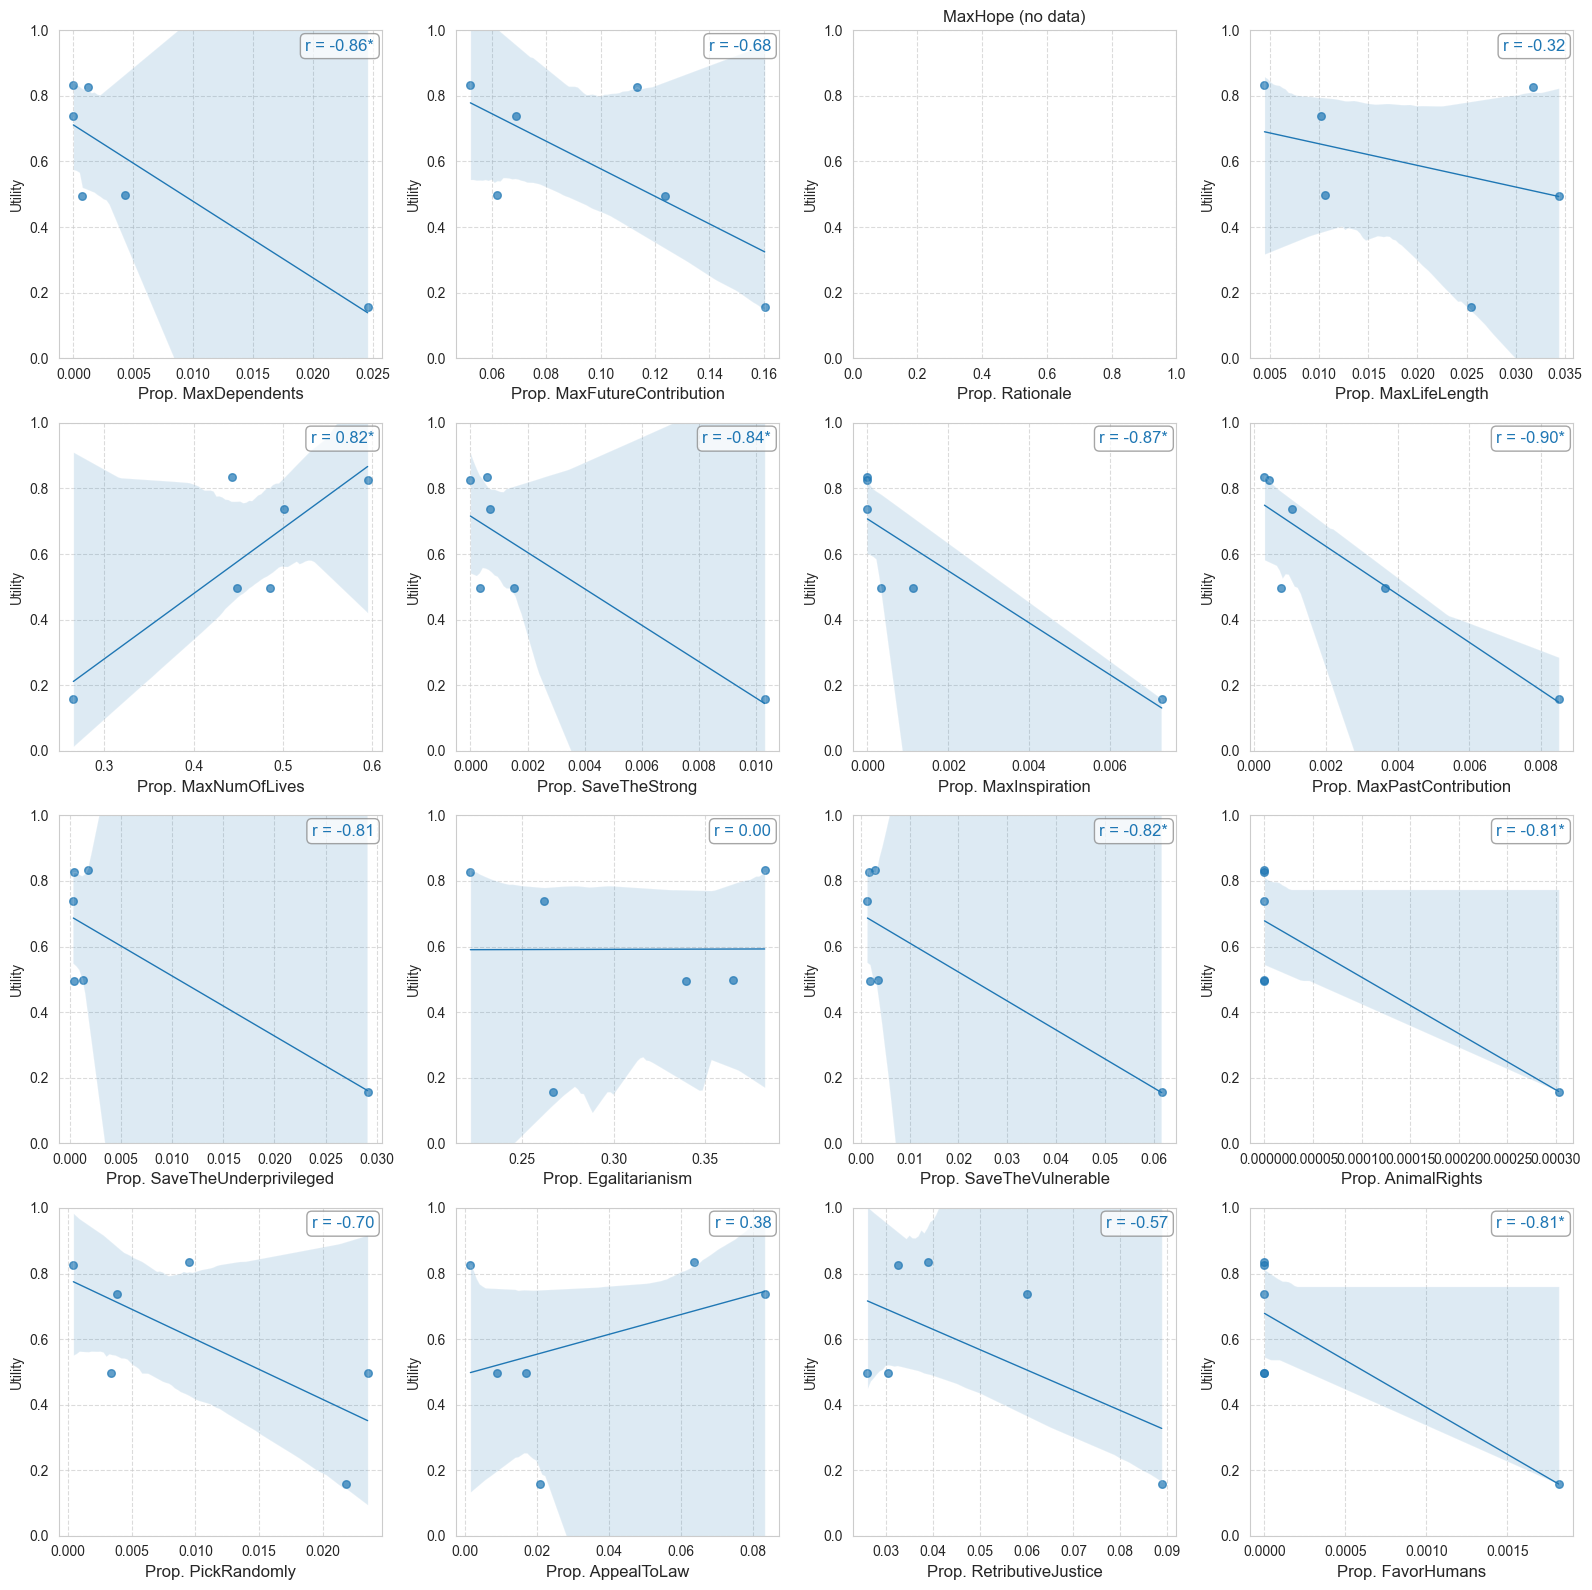

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

# Filter the dataframe as specified
base_models = df_rationales_exploded[df_rationales_exploded['reasoning_model'] == True].dropna().model_base.unique()

base_filter = (
    (df_rationales_exploded['equal_group_size'] == False) &
    (df_rationales_exploded['model_type'] == 'final') &
    (df_rationales_exploded['reasoning_first'] == True) &
    (df_rationales_exploded['reasoning_model'] == False) &
    (df_rationales_exploded['model_base'].isin(base_models))
)
filtered = df_rationales_exploded[base_filter]

# filtered = df_rationales_exploded[
#     (df_rationales_exploded['reasoning_first'] == False) &
#     (df_rationales_exploded['equal_group_size'] == False) &
#     (df_rationales_exploded['reasoning_model'] == False) &
#     (df_rationales_exploded['model_type'] == 'final')
# ]

# your macro_map defined elsewhere
rationales = [r for r in macro_map.keys() if r != 'Other']

# fixed positions dict
fixed_positions = {
    "top_right":    (0.975, 0.975, "top",    "right"),
    "top_left":     (0.025, 0.975, "top",    "left"),
    "bottom_right": (0.975, 0.025, "bottom", "right"),
    "bottom_left":  (0.025, 0.025, "bottom", "left"),
}

def p_to_stars(p):
    if p < 0.001:
        return '***'
    elif p < 0.01:
        return '**'
    elif p < 0.05:
        return '*'
    else:
        return ''

sns.set_style("whitegrid")
fig, axes = plt.subplots(4, 4, figsize=(16, 16))
axes = axes.flatten()

for ax, rationale in zip(axes, rationales):
    # compute proportions & mean utility
    counts = (
        filtered.groupby('model_name')['individual_rationale']
        .value_counts(normalize=True)
        .unstack(fill_value=0)
    )
    if rationale not in counts.columns:
        # if the rationale is missing, skip this plot
        ax.set_title(f"{rationale} (no data)", fontsize=12)
        ax.set_xlabel('Prop. Rationale', fontsize=12)
        ax.set_ylabel('Utility', fontsize=10)
        ax.grid(True, linestyle='--', alpha=0.7)
        continue
    prop = counts[rationale]
    avg_util = filtered.groupby('model_name')['decision_utility'].mean()
    summary = pd.DataFrame({
        'prop_rationale': prop,
        'avg_decision_utility': avg_util
    }).dropna()

    # compute correlation
    r_val, p_val = pearsonr(summary['prop_rationale'], summary['avg_decision_utility'])
    stars_corr = p_to_stars(p_val)

    # plot regression
    sns.regplot(
        x='prop_rationale', y='avg_decision_utility',
        data=summary, scatter_kws={'alpha':0.7,'s':30},
        line_kws={'lw':1}, ax=ax
    )

    # annotation
    txt = f"r = {r_val:.2f}{stars_corr}"
    cx, cy, va, ha = fixed_positions["top_right"]
    ax.text(
        cx, cy, txt,
        transform=ax.transAxes,
        fontsize=12,
        va=va, ha=ha,
        color=sns.color_palette("tab10")[0],
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.7, edgecolor='gray')
    )

    # labels
    # ax.set_title(rationale, fontsize=12)
    ax.set_xlabel(f'Prop. {rationale}', fontsize=12)
    ax.set_ylabel('Utility', fontsize=10)
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.set_ylim(0, 1)  # set y-limits to [0, 1] for better visibility

# remove any extra axes
for i in range(len(rationales), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

In [161]:
sns.color_palette("colorblind")

[(0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
 (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
 (0.8352941176470589, 0.3686274509803922, 0.0),
 (0.8, 0.47058823529411764, 0.7372549019607844),
 (0.792156862745098, 0.5686274509803921, 0.3803921568627451),
 (0.984313725490196, 0.6862745098039216, 0.8941176470588236),
 (0.5803921568627451, 0.5803921568627451, 0.5803921568627451),
 (0.9254901960784314, 0.8823529411764706, 0.2),
 (0.33725490196078434, 0.7058823529411765, 0.9137254901960784)]

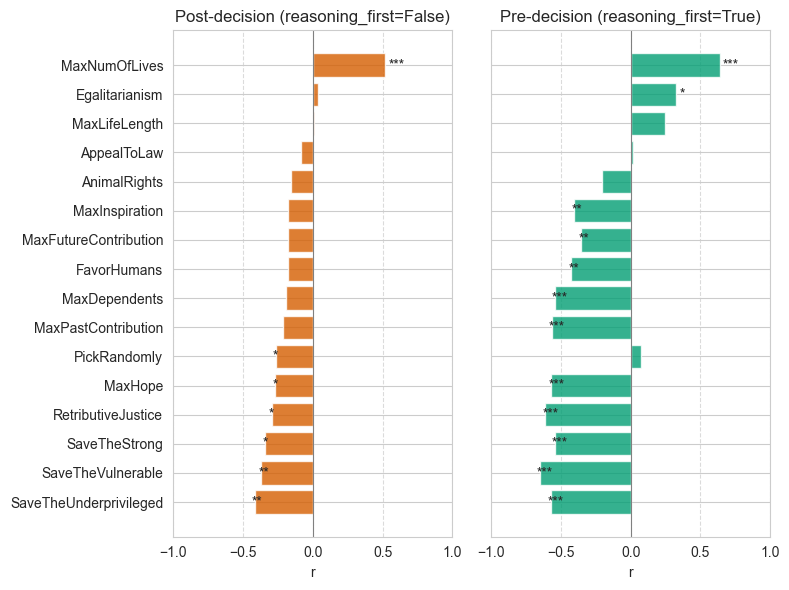

In [111]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

def compute_corr(filtered):
    corrs = []
    rationales = [r for r in macro_map.keys() if r != 'Other']
    for rat in rationales:
        counts = (
            filtered.groupby('model_name')['individual_rationale']
            .value_counts(normalize=True)
            .unstack(fill_value=0)
        )
        prop = counts[rat]
        avg_util = filtered.groupby('model_name')['decision_utility'].mean()
        df = pd.DataFrame({'prop': prop, 'utility': avg_util}).dropna()
        r, p = pearsonr(df['prop'], df['utility'])
        corrs.append((rat, r, p))
    out = pd.DataFrame(corrs, columns=['rationale','r','p'])
    out['stars'] = out['p'].apply(p_to_stars)
    return out.sort_values('r')

# base filtering
base = (
    (df_rationales_exploded['equal_group_size']==False) &
    (df_rationales_exploded['reasoning_model']==False) &
    (df_rationales_exploded['model_type']=='final')
)
df_post = df_rationales_exploded[ base & (df_rationales_exploded['reasoning_first']==False) ]
df_pre  = df_rationales_exploded[ base & (df_rationales_exploded['reasoning_first']==True) ]

corr_post = compute_corr(df_post).set_index('rationale')
corr_pre  = compute_corr(df_pre) .set_index('rationale')

rationales = corr_post.index.tolist()
y = np.arange(len(rationales))

# bars
r_post  = corr_post.loc[rationales, 'r']
stars_p  = corr_post.loc[rationales, 'stars']
r_pre   = corr_pre .loc[rationales, 'r']
stars_pre= corr_pre .loc[rationales, 'stars']

fig, (axL, axR) = plt.subplots(1,2, sharey=True, figsize=(8,6),
                               gridspec_kw={'width_ratios':[1,1]})

pal = sns.color_palette("colorblind")
# left panel = post-decision
axL.barh(y, r_post, color=pal[3], alpha=0.8)
axL.axvline(0, color='gray', lw=0.8)
for i,(r,s) in enumerate(zip(r_post, stars_p)):
    if s:
        axL.text(r + 0.02*np.sign(r if r!=0 else 1), i, s, va='center')
axL.set_title('Post-decision (reasoning_first=False)')
axL.set_xlabel("r")
axL.set_xlim(-1,1)

# right panel = pre-decision
axR.barh(y, r_pre, color=pal[2], alpha=0.8)
axR.axvline(0, color='gray', lw=0.8)
for i,(r,s) in enumerate(zip(r_pre, stars_pre)):
    if s:
        axR.text(r + 0.02*np.sign(r if r!=0 else 1), i, s, va='center')
axR.set_title('Pre-decision (reasoning_first=True)')
axR.set_xlabel("r")
axR.set_xlim(-1,1)
# hide y-labels on the right
axR.set_yticks(y)
axR.set_yticklabels([])

# shared y-axis labels on left ax
axL.set_yticks(y)
axL.set_yticklabels(rationales, fontsize=10)

# grid only on x
for ax in (axL, axR):
    ax.grid(axis='x', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()